# Предобработка данных для рекомендательной системы

In [1]:
import pandas as pd


class Constants:
    USER_ID = "user_id"
    ITEM_ID = "item_id"
    TIMESTAMP = "time"

    TRANSACTIONS_PATH = "/Users/alfa/Documents/diplom/graphnn-recommendation-system/data/transactions_train.csv"
    CUSTOMERS_PATH = "/Users/alfa/Documents/diplom/graphnn-recommendation-system/data/customers.csv"
    ARTICLES_PATH = "/Users/alfa/Documents/diplom/graphnn-recommendation-system/data/articles.csv"

    RESULT_TRANSACTIONS_PATH = "/Users/alfa/Documents/diplom/graphnn-recommendation-system/data/processed_transactions_train.csv"
    RESULT_CUSTOMERS_PATH = "/Users/alfa/Documents/diplom/graphnn-recommendation-system/data/processed_customers_train.csv"
    RESULT_ARTICLES_PATH = "/Users/alfa/Documents/diplom/graphnn-recommendation-system/data/processed_articles_train.csv"


In [2]:
# def prepare_filtered_dataset(
#     transactions: pd.DataFrame,
#     num_customers: int = 100,
#     num_articles: int = 100,
#     min_articles_per_user: int = 5,
#     min_users_per_article: int = 5,
# ) -> tuple:
#     """
#     Отбираем сбалансированный набор данных:
#     - num_customers: количество пользователей для отбора
#     - min_articles_per_user: минимальное количество покупок у пользователя
#     - min_users_per_article: минимальное количество покупателей у товара
#     """

#     # Фильтрация товаров
#     article_popularity = transactions[Constants.ITEM_ID].value_counts()
#     popular_articles = article_popularity[article_popularity >= min_users_per_article]

#     # Отбираем топ-N самых активных пользователей
#     selected_items = popular_articles.head(num_articles).index

#     # Окончательный набор данных
#     filtered_data = transactions[
#         transactions[Constants.ITEM_ID].isin(selected_items)
#     ]

#     # Первичная фильтрация пользователей
#     user_purchase_counts = filtered_data[Constants.USER_ID].value_counts()
#     active_users = user_purchase_counts[user_purchase_counts >= min_articles_per_user]

#     # Отбираем топ-N самых активных пользователей
#     selected_users = active_users.head(num_customers).index

#     # Фильтруем транзакции только по выбранным пользователям
#     final_data = filtered_data[filtered_data[Constants.USER_ID].isin(selected_users)]
#     final_data = final_data.reset_index(drop=True)

#     print(f"Исходный размер данных: {len(transactions)} транзакций")
#     print(f"Отобрано пользователей: {len(selected_users)}")
#     print(f"Отобрано товаров: {len(selected_items)}")
#     print(f"Финальный размер данных: {len(final_data)} транзакций")

#     return final_data, selected_users, selected_items


In [3]:
def prepare_balanced_dataset(
    transactions: pd.DataFrame,
    articles: pd.DataFrame,
    num_articles_per_type: int = 50,
    num_customers: int = 500,
    min_articles_per_user: int = 5,
    min_users_per_article: int = 5,
) -> tuple:
    """
    Формирует сбалансированный датасет:
    - одинаковое количество артикулов на каждый product_type_name (если возможно)
    - одинаковое количество взаимодействий с каждым product_type_name
    - отбирает пользователей с минимум min_articles_per_user покупками
    """

    # Считаем популярность товаров
    article_popularity = transactions['item_id'].value_counts()
    popular_articles = article_popularity[article_popularity >= min_users_per_article].index

    # Фильтруем articles по популярным
    filtered_articles = articles[articles['item_id'].isin(popular_articles)]

    # Оставляем только те product_type_name, где достаточно товаров
    type_counts = filtered_articles['product_type_name'].value_counts()
    eligible_types = type_counts[type_counts >= num_articles_per_type].index

    print(f"Всего типов с достаточным числом товаров: {len(eligible_types)}")

    # Формируем финальный список артикулов по каждому типу
    selected_items = []
    for pt in eligible_types:
        items_in_type = filtered_articles[filtered_articles['product_type_name'] == pt]['item_id'].sample(
            num_articles_per_type, random_state=42
        ).tolist()
        selected_items.extend(items_in_type)

    # Фильтруем транзакции по этим артиклам
    filtered_data = transactions[transactions['item_id'].isin(selected_items)]

    # Считаем покупки по пользователям
    user_purchase_counts = filtered_data['user_id'].value_counts()

    # Отбираем пользователей с минимум min_articles_per_user покупками
    eligible_users = user_purchase_counts[user_purchase_counts >= min_articles_per_user].index

    # Берём случайные num_customers из eligible_users
    selected_users = pd.Series(eligible_users).sample(
        min(num_customers, len(eligible_users)), random_state=42
    ).tolist()

    # Финальный датасет
    final_data = filtered_data[filtered_data['user_id'].isin(selected_users)].reset_index(drop=True)

    print(f"Всего отобрано product_type_name: {len(eligible_types)}")
    print(f"Отобрано товаров: {len(selected_items)}")
    print(f"Отобрано пользователей: {len(selected_users)}")
    print(f"Финальный размер данных: {len(final_data)} транзакций")

    return final_data, selected_users, selected_items, eligible_types.tolist()


In [4]:
transactions = pd.read_csv(Constants.TRANSACTIONS_PATH)
transactions = transactions.rename(
    columns={
        "t_dat": Constants.TIMESTAMP,
        "customer_id": Constants.USER_ID,
        "article_id": Constants.ITEM_ID,
    }
)
transactions[Constants.USER_ID] = transactions[Constants.USER_ID].astype(str)
transactions[Constants.ITEM_ID] = transactions[Constants.ITEM_ID].astype(str)

customers = pd.read_csv(Constants.CUSTOMERS_PATH)
customers = (
    customers.rename(
        columns={
            "customer_id": Constants.USER_ID,
            "Active": "is_active",
            "age": "age",
        }
    )
    .drop(columns=["FN", "postal_code"])
)
customers[Constants.USER_ID] = customers[Constants.USER_ID].astype(str)

articles = pd.read_csv(Constants.ARTICLES_PATH)
articles = (
    articles.rename(
        columns={"article_id": Constants.ITEM_ID}
    )
    [[
        Constants.ITEM_ID,
        "prod_name",
        "product_type_name",
        "product_group_name",
        "colour_group_name",
        "detail_desc",
    ]]
)
product_type_names = [
    "Dress",
    "Sweater",
    "T-shirt",
    "Top",
    "Blouse",
    "Jacket",
    "Shorts",
    "Shirt",
    "Hoodie",
    "Sneakers",
    "Cardigan",
    "Boots",
    "Sandals",
    "Polo shirt",
    "Other shoe",
]
# articles = articles[
#     articles["product_group_name"].isin(
#         ["Garment Upper body", "Garment Lower body", "Garment Full body", "Shoes"]
#     )
# ]
articles = articles[
    articles["product_type_name"].isin(product_type_names)
]
articles[Constants.ITEM_ID] = articles[Constants.ITEM_ID].astype(str)

In [5]:
articles.head()

,item_id,prod_name,product_type_name,product_group_name,colour_group_name,detail_desc
11,112679048,SWEATSHIRT OC,Sweater,Garment Upper body,Grey,Sweatshirt in soft organic cotton with a pres...
12,112679052,SWEATSHIRT OC,Sweater,Garment Upper body,Light Blue,Sweatshirt in soft organic cotton with a pres...
15,116379047,Frugan longsleeve,Top,Garment Upper body,Dark Blue,Fitted top in soft stretch jersey with a wide ...
40,145872001,Dorian l/s basic,Sweater,Garment Upper body,Black,"Long-sleeved sports top in fast-drying, breath..."
41,145872037,Dorian l/s basic,Sweater,Garment Upper body,Dark Grey,"Long-sleeved sports top in fast-drying, breath..."


In [6]:
customers.head()

,user_id,is_active,club_member_status,fashion_news_frequency,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,ACTIVE,NONE,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,ACTIVE,NONE,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,ACTIVE,NONE,24.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,ACTIVE,NONE,54.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,ACTIVE,Regularly,52.0


In [7]:
transactions.head()

,time,user_id,item_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [8]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set(style="whitegrid")
# plt.rcParams["figure.figsize"] = (10, 6)

# # 1. Распределение цен товаров
# plt.hist(transactions['price'], bins=50, color='skyblue')
# plt.title('Распределение цен товаров')
# plt.xlabel('Цена')
# plt.ylabel('Количество транзакций')
# plt.grid(True)
# plt.show()

# # 2. Распределение возрастов клиентов
# plt.hist(customers['age'].dropna(), bins=30, color='salmon')
# plt.title('Распределение возрастов клиентов')
# plt.xlabel('Возраст')
# plt.ylabel('Количество клиентов')
# plt.grid(True)
# plt.show()

# # 3. Топ-10 популярных категорий товаров
# top_types = articles['product_type_name'].value_counts().head(10)
# top_types.plot(kind='bar', color='mediumseagreen')
# plt.title('Топ-10 популярных категорий товаров')
# plt.ylabel('Количество товаров')
# plt.xticks(rotation=45)
# plt.grid(axis='y')
# plt.show()

# # 4. Топ-10 популярных товаров по количеству покупок
# top_items = transactions['item_id'].value_counts().head(10)
# top_items.plot(kind='bar', color='mediumpurple')
# plt.title('Топ-10 популярных товаров по количеству покупок')
# plt.ylabel('Количество транзакций')
# plt.xticks(rotation=45)
# plt.grid(axis='y')
# plt.show()

# # 5. Распределение транзакций по каналам продаж
# sales_channel_counts = transactions['sales_channel_id'].value_counts()
# sales_channel_counts.plot(kind='pie', autopct='%1.1f%%', labels=['Онлайн', 'Оффлайн'], colors=['lightcoral', 'lightskyblue'])
# plt.title('Распределение транзакций по каналам продаж')
# plt.ylabel('')
# plt.show()

# # 6. Топ-10 цветовых групп товаров
# top_colours = articles['colour_group_name'].value_counts().head(10)
# sns.barplot(x=top_colours.values, y=top_colours.index, palette='viridis')
# plt.title('Топ-10 цветовых групп товаров')
# plt.xlabel('Количество товаров')
# plt.ylabel('Цветовая группа')
# plt.grid(axis='x')
# plt.show()

In [9]:
# # Соединяем транзакции с клиентами для анализа
# merged = transactions.merge(customers, on='user_id', how='left')

# # Выбираем только числовые столбцы
# corr_data = merged[['price', 'age']].corr()

# sns.heatmap(corr_data, annot=True, cmap='coolwarm')
# plt.title('Корреляция между ценой и возрастом клиентов')
# plt.show()

In [10]:
# # Преобразуем дату в datetime формат
# transactions['time'] = pd.to_datetime(transactions['time'])

# # Группируем по дате
# daily_transactions = transactions.groupby(transactions['time'].dt.date).size()

# daily_transactions.plot()
# plt.title('Динамика количества покупок по дням')
# plt.xlabel('Дата')
# plt.ylabel('Количество покупок')
# plt.grid(True)
# plt.show()

In [11]:
# # Добавим возраст к транзакциям
# merged = transactions.merge(customers[['user_id', 'age']], on='user_id', how='left')

# # Фильтруем по валидным возрастам
# merged = merged[(merged['age'] > 10) & (merged['age'] < 100)]

# # Группировка по возрасту
# avg_price_by_age = merged.groupby('age')['price'].mean()

# avg_price_by_age.plot(color='darkorange')
# plt.title('Средняя цена покупки по возрасту')
# plt.xlabel('Возраст')
# plt.ylabel('Средняя цена')
# plt.grid(True)
# plt.show()

In [12]:
# # Объединяем транзакции с товарами и клиентами
# full_data = transactions.merge(articles[['item_id', 'product_type_name']], on='item_id', how='left')
# full_data = full_data.merge(customers[['user_id', 'age']], on='user_id', how='left')
# full_data = full_data[(full_data['age'] > 10) & (full_data['age'] < 100)]

# # Выбираем топ-5 категорий
# top_categories = full_data['product_type_name'].value_counts().head(5).index
# filtered_data = full_data[full_data['product_type_name'].isin(top_categories)]

# # Создаём сводную таблицу
# heatmap_data = pd.pivot_table(
#     filtered_data, 
#     index='product_type_name', 
#     columns='age', 
#     values='price', 
#     aggfunc='count', 
#     fill_value=0
# )

# # Строим тепловую карту
# sns.heatmap(heatmap_data, cmap='YlGnBu')
# plt.title('Популярность категорий товаров по возрастам')
# plt.xlabel('Возраст')
# plt.ylabel('Категория товара')
# plt.show()


In [13]:
# filtered_transactions, selected_users, selected_items = prepare_filtered_dataset(transactions=transactions)
filtered_transactions, selected_users, selected_items, eligible_types = prepare_balanced_dataset(
    transactions=transactions,
    articles=articles,
    num_articles_per_type=100,
    num_customers=1000,
    min_articles_per_user=5,
    min_users_per_article=500,
)

filtered_customers = customers[customers[Constants.USER_ID].isin(selected_users)]
filtered_customers = filtered_customers.reset_index(drop=True)
filtered_articles = articles[articles[Constants.ITEM_ID].isin(selected_items)]
filtered_articles = filtered_articles.reset_index(drop=True)

Всего типов с достаточным числом товаров: 10
Всего отобрано product_type_name: 10
Отобрано товаров: 1000
Отобрано пользователей: 1000
Финальный размер данных: 7692 транзакций


In [14]:
filtered_articles["product_group_name"].value_counts()

Garment Upper body    800
Garment Lower body    100
Garment Full body     100
Name: product_group_name, dtype: int64

In [15]:
filtered_articles["item_id"].unique().tolist()

['237347043',
 '237347044',
 '305304019',
 '337777001',
 '381038026',
 '392938002',
 '395127006',
 '396135007',
 '396135058',
 '398089004',
 '398089007',
 '399061008',
 '399061012',
 '399061015',
 '399061019',
 '399061026',
 '399061028',
 '414577001',
 '443696015',
 '446224001',
 '446224013',
 '446224014',
 '446224035',
 '453765004',
 '456163009',
 '456163028',
 '456163030',
 '456163034',
 '456163048',
 '456163051',
 '456163060',
 '456163062',
 '456163065',
 '456163069',
 '456163070',
 '456163083',
 '456163086',
 '469682004',
 '474461002',
 '474461006',
 '479095001',
 '484108008',
 '484205009',
 '485973011',
 '488546001',
 '496111020',
 '496762005',
 '497640002',
 '501616020',
 '501616074',
 '501722005',
 '501820004',
 '501820006',
 '501820008',
 '504152008',
 '504152011',
 '505224005',
 '505230006',
 '506166049',
 '507909004',
 '507909023',
 '507909024',
 '507909027',
 '507910021',
 '508691010',
 '514577018',
 '516000087',
 '516000098',
 '516903022',
 '516903026',
 '519516002',
 '5195

In [16]:
filtered_transactions

,time,user_id,item_id,price,sales_channel_id
0,2018-09-20,3ebd228cc8888aa9196ec1270170e7ba851a69b811ed25...,647334001,0.059305,2
1,2018-09-20,3ebd228cc8888aa9196ec1270170e7ba851a69b811ed25...,647334001,0.059305,2
2,2018-09-20,6256c45dbc0a5ea1dcade82220d7fa55511cee59f60b55...,661162001,0.033881,2
3,2018-09-20,aed8af4cd22faa4f7ba72a42451f451dc80b03fa451523...,610744006,0.015237,2
4,2018-09-20,c4ec77056bf79178fd60596766892de851951841912f42...,615141002,0.025407,2
...,...,...,...,...,...
7687,2020-09-22,6e9fe8a109c6ec6ebbecb3f1db961a67fce3123bea9360...,875350003,0.016932,1
7688,2020-09-22,6e9fe8a109c6ec6ebbecb3f1db961a67fce3123bea9360...,924605001,0.016932,1
7689,2020-09-22,6e9fe8a109c6ec6ebbecb3f1db961a67fce3123bea9360...,924605001,0.016932,1
7690,2020-09-22,80618ccc1348e887cf5fb2c84ffc84dc09e435b83a16ab...,850917001,0.025407,1


In [17]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

# 1. Загрузка и сортировка данных по времени
print("Исходные данные:")
print(filtered_transactions.head())

# Сортируем по времени (если есть столбец времени)
if 'time' in filtered_transactions.columns:
    filtered_transactions = filtered_transactions.sort_values('time')

# 2. Разделение исходного датафрейма на train/test (80/20) без перемешивания
train_df, test_df = train_test_split(
    filtered_transactions,
    test_size=0.2,
    shuffle=False  # Важно для временного разделения
)

print(f"\nРазделение данных:")
print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

# 3. Создание словарей для маппинга
unique_users = pd.concat([train_df['user_id'], test_df['user_id']]).unique()
unique_items = pd.concat([train_df['item_id'], test_df['item_id']]).unique()

user_to_idx = {u: i for i, u in enumerate(unique_users)}
item_to_idx = {i: j + len(unique_users) for j, i in enumerate(unique_items)}  # Сдвиг для item_id

# 4. Создание графов для train и test отдельно
def create_graph_edges(df, user_to_idx, item_to_idx):
    src = [user_to_idx[u] for u in df['user_id']]
    dst = [item_to_idx[i] for i in df['item_id']]
    return torch.tensor([src, dst], dtype=torch.long)

train_edge_index = create_graph_edges(train_df, user_to_idx, item_to_idx)
test_edge_index = create_graph_edges(test_df, user_to_idx, item_to_idx)

# 5. Создание общего графа для PyG
num_nodes = len(unique_users) + len(unique_items)
data_pyg = Data(
    edge_index=torch.cat([train_edge_index, test_edge_index], dim=1),
    num_nodes=num_nodes,
    train_mask=torch.cat([
        torch.ones(train_edge_index.shape[1], dtype=torch.bool),
        torch.zeros(test_edge_index.shape[1], dtype=torch.bool)
    ]),
    test_mask=torch.cat([
        torch.zeros(train_edge_index.shape[1], dtype=torch.bool),
        torch.ones(test_edge_index.shape[1], dtype=torch.bool)
    ])
)

print("\nИтоговые графы:")
print(f"Всего узлов: {num_nodes}")
print(f"Train edges: {train_edge_index.shape[1]}")
print(f"Test edges: {test_edge_index.shape[1]}")
print(f"Общие пользователи: {len(set(train_df['user_id']) & set(test_df['user_id']))}")

Исходные данные:
         time                                            user_id    item_id  \
0  2018-09-20  3ebd228cc8888aa9196ec1270170e7ba851a69b811ed25...  647334001   
1  2018-09-20  3ebd228cc8888aa9196ec1270170e7ba851a69b811ed25...  647334001   
2  2018-09-20  6256c45dbc0a5ea1dcade82220d7fa55511cee59f60b55...  661162001   
3  2018-09-20  aed8af4cd22faa4f7ba72a42451f451dc80b03fa451523...  610744006   
4  2018-09-20  c4ec77056bf79178fd60596766892de851951841912f42...  615141002   

      price  sales_channel_id  
0  0.059305                 2  
1  0.059305                 2  
2  0.033881                 2  
3  0.015237                 2  
4  0.025407                 2  

Разделение данных:
Train size: 6153
Test size: 1539

Итоговые графы:
Всего узлов: 1980
Train edges: 6153
Test edges: 1539
Общие пользователи: 601


## LightGCN

In [18]:
import numpy as np
from collections import defaultdict

def calculate_metrics(model, edge_index, num_users, num_items, k=10):
    """Вычисление Recall@K и NDCG@K"""
    model.eval()
    with torch.no_grad():
        user_emb, item_emb = model(edge_index)
        
        # Собираем ground truth: какие товары реально взаимодействовали с пользователем
        test_dict = defaultdict(list)
        src, dst = edge_index.cpu().numpy()
        for u, i in zip(src, dst):
            test_dict[u].append(i)
        
        # Для каждого пользователя предсказываем топ-K товаров
        recalls = []
        ndcgs = []
        
        # Вычисляем scores для всех пар пользователь-товар
        scores = user_emb @ item_emb.T  # [num_users, num_items]
        
        for u in test_dict:
            true_items = test_dict[u]
            if len(true_items) == 0:
                continue
                
            # Получаем предсказания для текущего пользователя
            user_scores = scores[u]
            
            # Исключаем товары, которые уже были в обучающих данных
            _, top_indices = torch.topk(user_scores, k=k)
            top_items = top_indices.cpu().numpy()
            
            # Расчет Recall@K
            hits = len(set(top_items) & set(true_items))
            recall = hits / min(len(true_items), k)
            recalls.append(recall)
            
            # Расчет NDCG@K
            relevance = np.isin(top_items, true_items).astype(float)
            dcg = np.sum(relevance / np.log2(np.arange(2, k+2)))
            idcg = np.sum([1.0 / np.log2(i+1) for i in range(1, min(len(true_items), k)+1)])
            ndcg = dcg / idcg if idcg > 0 else 0
            ndcgs.append(ndcg)
    
    return np.mean(recalls), np.mean(ndcgs)


Загрузка данных...
         time                                            user_id    item_id  \
0  2018-09-20  3ebd228cc8888aa9196ec1270170e7ba851a69b811ed25...  647334001   
1  2018-09-20  3ebd228cc8888aa9196ec1270170e7ba851a69b811ed25...  647334001   
2  2018-09-20  6256c45dbc0a5ea1dcade82220d7fa55511cee59f60b55...  661162001   
3  2018-09-20  aed8af4cd22faa4f7ba72a42451f451dc80b03fa451523...  610744006   
4  2018-09-20  c4ec77056bf79178fd60596766892de851951841912f42...  615141002   

      price  sales_channel_id  
0  0.059305                 2  
1  0.059305                 2  
2  0.033881                 2  
3  0.015237                 2  
4  0.025407                 2  


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0:
  Loss: 551.5084
  Train Recall@10: 0.0323
  Test Recall@10: 0.0393
  Test NDCG@10: 0.0287
  Diversity: -0.6939
  Coverage: 0.5163
  LR: 0.001000
Epoch 10:
  Loss: 76.2347
  Train Recall@10: 0.0317
  Test Recall@10: 0.0378
  Test NDCG@10: 0.0271
  Diversity: 0.6274
  Coverage: 0.4673
  LR: 0.001000
Epoch 20:
  Loss: 30.9356
  Train Recall@10: 0.0359
  Test Recall@10: 0.0443
  Test NDCG@10: 0.0307
  Diversity: 0.8704
  Coverage: 0.3827
  LR: 0.001000
Epoch 30:
  Loss: 15.1317
  Train Recall@10: 0.0406
  Test Recall@10: 0.0410
  Test NDCG@10: 0.0283
  Diversity: 0.9455
  Coverage: 0.4112
  LR: 0.001000
Epoch 40:
  Loss: 8.8424
  Train Recall@10: 0.0421
  Test Recall@10: 0.0348
  Test NDCG@10: 0.0250
  Diversity: 0.9797
  Coverage: 0.4847
  LR: 0.001000
Epoch 50:
  Loss: 5.6848
  Train Recall@10: 0.0594
  Test Recall@10: 0.0374
  Test NDCG@10: 0.0242
  Diversity: 0.9935
  Coverage: 0.6235
  LR: 0.000500


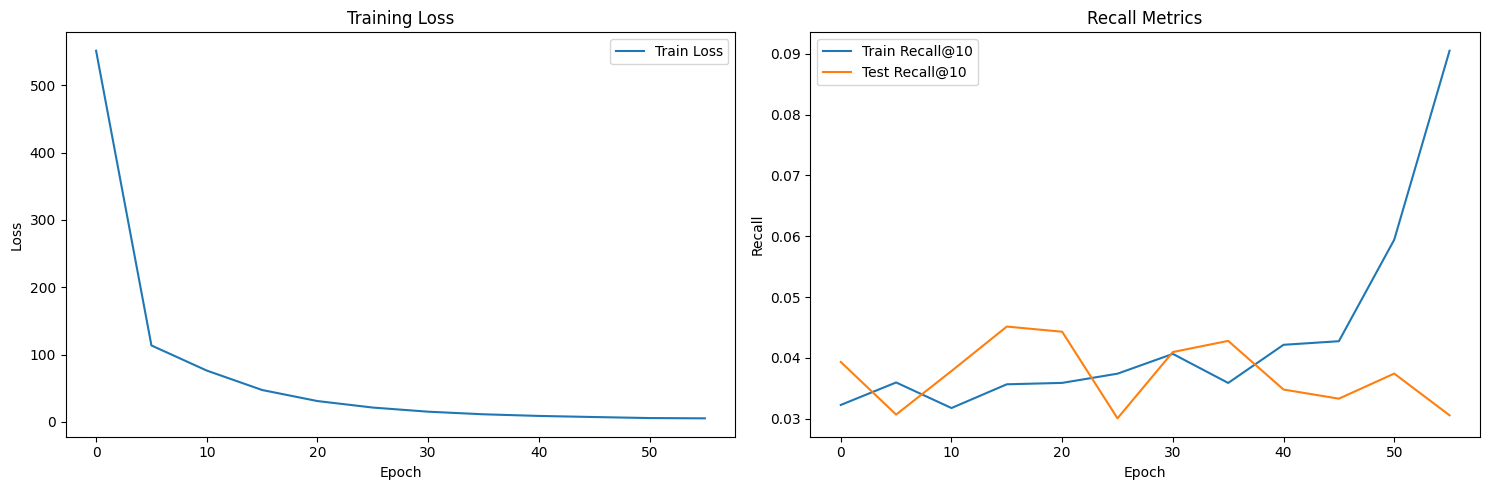


Рекомендации для пользователя 3ebd228cc8888aa9196ec1270170e7ba851a69b811ed25a56d428b23e447ea9e:
['679854009', '717490001', '638355001', '786304002', '706655001', '717365001', '760123001', '825169001', '685844002', '746994002']


In [20]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import LGConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from collections import defaultdict
from itertools import combinations
from sklearn.preprocessing import StandardScaler

# 1. Улучшенная загрузка и предобработка данных
print("Загрузка данных...")
print(filtered_transactions.head())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Добавим обработку дополнительных признаков товаров
# Предположим, у нас есть датафрейм item_features с дополнительной информацией
if 'item_features' not in globals():
    # Создаем фиктивные признаки для примера
    item_features = pd.get_dummies(filtered_transactions['item_id'].astype(str)).T
    item_features = item_features.reset_index().rename(columns={'index': 'item_id'})

# Нормализация признаков
scaler = StandardScaler()
item_feature_values = scaler.fit_transform(item_features.iloc[:, 1:].values)
item_features_normalized = pd.DataFrame(item_feature_values, 
                                      index=item_features['item_id'],
                                      columns=item_features.columns[1:])

# 2. Создание числовых индексов с учетом дополнительных признаков
unique_users = filtered_transactions['user_id'].unique()
unique_items = filtered_transactions['item_id'].unique()

user_to_idx = {u: i for i, u in enumerate(unique_users)}
item_to_idx = {i: j for j, i in enumerate(unique_items)}

# Подготовка тензора дополнительных признаков
item_feature_tensor = torch.FloatTensor(
    item_features_normalized.loc[unique_items].values
).to(device)

# 3. Разделение на train/test с временным учетом
train_df, test_df = train_test_split(
    filtered_transactions,
    test_size=0.4,
    shuffle=False
)

# 4. Создание взвешенного графа
def create_weighted_graph_edges(df, user_map, item_map):
    # Подсчет частоты взаимодействий и времени
    freq = df.groupby(['user_id', 'item_id']).size().reset_index(name='freq')
    last_time = df.groupby(['user_id', 'item_id'])['time'].max().reset_index()
    
    merged = pd.merge(freq, last_time, on=['user_id', 'item_id'])
    merged['weight'] = merged['freq'] * (1 + pd.to_datetime(merged['time']).dt.year - 2018)
    
    src = [user_map[u] for u in merged['user_id']]
    dst = [item_map[i] for i in merged['item_id']]
    weights = torch.tensor(merged['weight'].values, dtype=torch.float)
    
    return torch.tensor([src, dst], dtype=torch.long), weights

train_edge_index, train_weights = create_weighted_graph_edges(train_df, user_to_idx, item_to_idx)
test_edge_index, test_weights = create_weighted_graph_edges(test_df, user_to_idx, item_to_idx)

# 5. Создание PyG Data объекта с весами
num_users = len(unique_users)
num_items = len(unique_items)

data_pyg = Data(
    edge_index=torch.cat([train_edge_index, test_edge_index], dim=1),
    edge_attr=torch.cat([train_weights, test_weights]),
    num_nodes=num_users + num_items,
    train_mask=torch.cat([
        torch.ones(train_edge_index.shape[1], dtype=torch.bool),
        torch.zeros(test_edge_index.shape[1], dtype=torch.bool)
    ]),
    test_mask=torch.cat([
        torch.zeros(train_edge_index.shape[1], dtype=torch.bool),
        torch.ones(test_edge_index.shape[1], dtype=torch.bool)
    ])
)

# 6. Улучшенная модель LightGCN
class EnhancedLightGCN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=128, num_layers=3, 
                 dropout=0.1, item_features=None):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.dropout = dropout
        
        # Основные эмбеддинги
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
        
        # Дополнительные признаки товаров
        if item_features is not None:
            self.item_feature_proj = nn.Linear(item_features.shape[1], embedding_dim)
            self.item_features = item_features
        else:
            self.item_feature_proj = None
        
        # Улучшенные слои с residual connections
        self.convs = nn.ModuleList([LGConv() for _ in range(num_layers)])
        self.dropout = nn.Dropout(p=dropout)
        self.attention = nn.Parameter(torch.ones(num_layers + 1, 1, 1))

    def forward(self, edge_index):
        user_emb = self.dropout(self.user_emb.weight)
        item_emb = self.dropout(self.item_emb.weight)
        
        # Добавление side information
        if self.item_feature_proj is not None:
            item_emb = item_emb + self.item_feature_proj(self.item_features)
        
        all_emb = torch.cat([user_emb, item_emb])
        
        embs = [all_emb]
        for conv in self.convs:
            new_emb = conv(all_emb, edge_index)
            new_emb = self.dropout(new_emb)
            # Residual connection
            new_emb = new_emb + embs[-1] if len(embs) > 0 else new_emb
            embs.append(new_emb)
        
        # Взвешенное усреднение с вниманием
        stacked_embs = torch.stack(embs, dim=0)
        attention_weights = torch.softmax(self.attention, dim=0)
        final_emb = (stacked_embs * attention_weights).sum(dim=0)
        
        return final_emb[:self.num_users], final_emb[self.num_users:]

# 7. Улучшенные функции потерь и метрик
def enhanced_loss(user_emb, item_emb, edge_index, weights, num_items, device, lambda_reg=0.01):
    src, dst = edge_index
    
    # Генерация негативных примеров
    neg_items = torch.randint(0, num_items, (len(dst),), device=device)
    
    # Weighted BPR loss
    pos_scores = (user_emb[src] * item_emb[dst]).sum(dim=1)
    neg_scores = (user_emb[src] * item_emb[neg_items]).sum(dim=1)
    bpr_loss = -torch.log(torch.sigmoid(pos_scores - neg_scores)) * weights.to(device)
    bpr_loss = bpr_loss.mean()
    
    # Контрастная потеря
    user_norm = F.normalize(user_emb[src], p=2, dim=1)
    item_pos_norm = F.normalize(item_emb[dst], p=2, dim=1)
    item_neg_norm = F.normalize(item_emb[neg_items], p=2, dim=1)
    
    contrast_loss = -torch.log(
        torch.exp((user_norm * item_pos_norm).sum(1) / 0.1) / (
        torch.exp((user_norm * item_pos_norm).sum(1) / 0.1) + 
        torch.exp((user_norm * item_neg_norm).sum(1) / 0.1)
    )).mean()
    
    # Регуляризация
    l2_reg = lambda_reg * (user_emb.norm(2).pow(2) + item_emb.norm(2).pow(2))
    
    return bpr_loss + 0.5 * contrast_loss + l2_reg

def enhanced_metrics(model, edge_index, weights, num_users, num_items, k=10):
    model.eval()
    with torch.no_grad():
        user_emb, item_emb = model(edge_index)
        
        test_dict = {}
        src, dst = edge_index.cpu().numpy()
        for u, i in zip(src, dst):
            test_dict.setdefault(u, []).append(i)
        
        recalls, ndcgs, diversities = [], [], []
        item_counts = defaultdict(int)
        scores = user_emb @ item_emb.T
        
        for u in test_dict:
            true_items = test_dict[u]
            user_scores = scores[u]
            
            _, top_k = torch.topk(user_scores, k=k)
            top_items = top_k.cpu().numpy()
            
            # Обновление счетчиков для coverage
            for item in top_items:
                item_counts[item] += 1
            
            # Recall
            hits = len(set(top_items) & set(true_items))
            recalls.append(hits / min(len(true_items), k))
            
            # NDCG
            relevance = np.isin(top_items, true_items).astype(float)
            dcg = np.sum(relevance / np.log2(np.arange(2, k+2)))
            idcg = np.sum(1.0 / np.log2(np.arange(2, min(len(true_items), k)+2)))
            ndcgs.append(dcg / idcg if idcg > 0 else 0)
            
            # Diversity (попарное сходство)
            if len(top_items) > 1:
                item_pairs = list(combinations(top_items, 2))
                if item_pairs:
                    sim_sum = sum(item_emb[i] @ item_emb[j] for i, j in item_pairs)
                    diversities.append(1 - sim_sum.item() / len(item_pairs))
    
    # Coverage
    coverage = len(item_counts) / num_items
    
    return {
        'recall': np.mean(recalls),
        'ndcg': np.mean(ndcgs),
        'diversity': np.mean(diversities) if diversities else 0,
        'coverage': coverage
    }

# 8. Обучение улучшенной модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Инициализация модели
model = EnhancedLightGCN(
    num_users=num_users,
    num_items=num_items,
    embedding_dim=32,
    num_layers=10,
    dropout=0.1,
    item_features=item_feature_tensor
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True
)

# Подготовка данных
train_edge_index = data_pyg.edge_index[:, data_pyg.train_mask].to(device)
train_weights = data_pyg.edge_attr[data_pyg.train_mask].to(device)
test_edge_index = data_pyg.edge_index[:, data_pyg.test_mask].to(device)
test_weights = data_pyg.edge_attr[data_pyg.test_mask].to(device)

best_test_recall = 0
early_stop_counter = 0
patience = 15
history = []

for epoch in range(60):
    model.train()
    optimizer.zero_grad()
    
    user_emb, item_emb = model(train_edge_index)
    loss = enhanced_loss(
        user_emb, item_emb, 
        train_edge_index, 
        train_weights,
        num_items, 
        device,
        lambda_reg=0.05
    )
    
    loss.backward()
    optimizer.step()
    
    # Валидация
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            train_metrics = enhanced_metrics(
                model, train_edge_index, train_weights,
                num_users, num_items, k=10
            )
            test_metrics = enhanced_metrics(
                model, test_edge_index, test_weights,
                num_users, num_items, k=10
            )
            
            scheduler.step(test_metrics['recall'])
            
            # Сохранение истории
            history.append({
                'epoch': epoch,
                'train_loss': loss.item(),
                'train_recall': train_metrics['recall'],
                'test_recall': test_metrics['recall'],
                'test_ndcg': test_metrics['ndcg'],
                'diversity': test_metrics['diversity'],
                'coverage': test_metrics['coverage']
            })
            
            # Ранняя остановка
            if test_metrics['recall'] > best_test_recall:
                best_test_recall = test_metrics['recall']
                early_stop_counter = 0
                torch.save(model.state_dict(), 'best_enhanced_model.pth')
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
    
    # Логирование
    if epoch % 10 == 0:
        print(f"Epoch {epoch}:")
        print(f"  Loss: {loss.item():.4f}")
        print(f"  Train Recall@10: {history[-1]['train_recall']:.4f}")
        print(f"  Test Recall@10: {history[-1]['test_recall']:.4f}")
        print(f"  Test NDCG@10: {history[-1]['test_ndcg']:.4f}")
        print(f"  Diversity: {history[-1]['diversity']:.4f}")
        print(f"  Coverage: {history[-1]['coverage']:.4f}")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")

# 9. Визуализация результатов
history_df = pd.DataFrame(history)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_df['epoch'], history_df['train_loss'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['epoch'], history_df['train_recall'], label='Train Recall@10')
plt.plot(history_df['epoch'], history_df['test_recall'], label='Test Recall@10')
plt.title('Recall Metrics')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

# 10. Генерация рекомендаций
def generate_recommendations(model, user_id, k=10):
    model.eval()
    with torch.no_grad():
        user_idx = user_to_idx.get(user_id, -1)
        
        # user_emb, item_emb = model(data_pyg.edge_index.to(device))
        user_emb, item_emb = model(torch.tensor([[], []], dtype=torch.long).to(device))
        scores = user_emb[user_idx] @ item_emb.T
        
        _, top_k = torch.topk(scores, k=k)
        recommended_items = [unique_items[i] for i in top_k.cpu().numpy()]
        
        return recommended_items

# Пример использования
user_id = filtered_transactions['user_id'].iloc[0]  # Берем первого пользователя
recommendations = generate_recommendations(model, user_id)
print(f"\nРекомендации для пользователя {user_id}:")
print(recommendations)

In [34]:
# Пример использования
user_id = filtered_transactions['user_id'].iloc[151]  # Берем первого пользователя
recommendations = generate_recommendations(model, user_id)
print(f"\nРекомендации для пользователя {user_id}:")
print(recommendations)

history = filtered_transactions[filtered_transactions["user_id"] == user_id]["item_id"].unique()


Рекомендации для пользователя 15ea2fc0acbd0abc77361038a0d4e7f89ba07069f7869766e152e7da78a12e25:
['579541004', '772349014', '733106001', '690541003', '699620001', '718278009', '733106004', '675068002', '399061008', '683662019']


In [35]:
filtered_articles[
    filtered_articles["item_id"].isin(history)
]

,item_id,prod_name,product_type_name,product_group_name,colour_group_name,detail_desc
88,554598066,Nora T-shirt,T-shirt,Garment Upper body,Light Pink,"T-shirt in soft jersey with a round neck, shor..."
89,554598070,Nora T-shirt,T-shirt,Garment Upper body,Blue,"T-shirt in soft jersey with a round neck, shor..."
132,591466018,PRINCE ERIC BASIC TEE,T-shirt,Garment Upper body,Black,T-shirt in slub cotton jersey with sewn-in tur...
178,617322004,Glans tunic,Blouse,Garment Upper body,Black,Long-sleeved tunic in jersey crêpe with a roun...
739,781688001,DIV Carla Parka (1),Jacket,Garment Upper body,Black,Pile-lined parka in a cotton weave with padded...


In [36]:
filtered_articles[
    filtered_articles["item_id"].isin(recommendations)
]

,item_id,prod_name,product_type_name,product_group_name,colour_group_name,detail_desc
11,399061008,Jacket Slim,Jacket,Garment Upper body,Light Blue,"Fitted jacket in washed, stretch denim with bu..."
118,579541004,Calista (1),Cardigan,Garment Upper body,Dark Blue,"Cardigan in a soft, fine-knit viscose blend wi..."
324,675068002,Melrose,Shirt,Garment Upper body,White,Straight-cut shirt in an airy cotton weave wit...
358,683662019,Doris L/S,Top,Garment Upper body,Dark Red,Long-sleeved top in soft cotton jersey with ri...
415,690541003,Jan poplin shirt,Shirt,Garment Upper body,White,Straight-cut shirt in cotton poplin with a col...
468,699620001,Kiev super trash denim jacket,Jacket,Garment Upper body,Black,"Jacket in washed denim with hard-worn details,..."
532,718278009,Bird tee,T-shirt,Garment Upper body,Beige,"Loose-fitting, V-neck T-shirt in soft jersey m..."
573,733106001,Riviera S/S,Blouse,Garment Upper body,Dark Orange,"Blouse in a viscose weave with a draped front,..."
574,733106004,Riviera S/S,Blouse,Garment Upper body,Greenish Khaki,"Blouse in a viscose weave with a draped front,..."
715,772349014,Glamping.(1),Shorts,Garment Lower body,Yellowish Brown,Short shorts in lightweight sweatshirt fabric ...


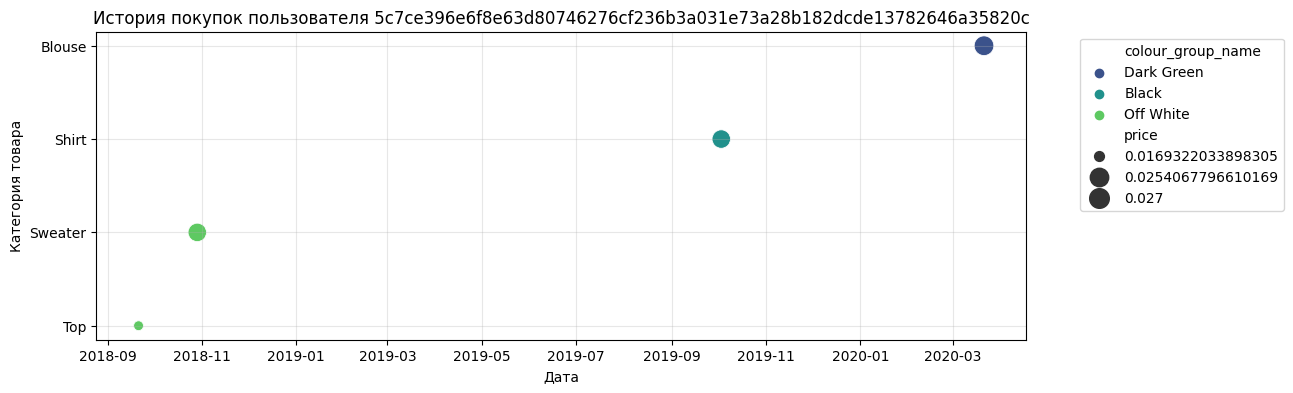

NameError: name 'edge_index' is not defined

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

class EnhancedRecommenderVisualizer:
    def __init__(self, model, user_to_idx, item_to_idx, transactions_df, articles_df):
        """
        Улучшенный визуализатор рекомендаций
        
        Args:
            model: Обученная модель LightGCN
            user_to_idx: Маппинг user_id -> индекс
            item_to_idx: Маппинг item_id -> индекс
            transactions_df: DataFrame с транзакциями
            articles_df: DataFrame с информацией о товарах
        """
        self.model = model
        self.user_to_idx = user_to_idx
        self.item_to_idx = item_to_idx
        self.transactions = transactions_df
        self.articles = articles_df
        self.idx_to_item = {v: k for k, v in item_to_idx.items()}
        self._prepare_data()

    def _prepare_data(self):
        """Предварительная обработка данных"""
        self.merged_data = self.transactions.merge(
            self.articles,
            on='item_id',
            how='left'
        )
        
    def get_user_history(self, user_id, top_n=5, plot=True):
        """
        Получить историю покупок пользователя с визуализацией
        
        Args:
            user_id: ID пользователя
            top_n: Количество последних покупок для отображения
            plot: Флаг отображения графика
            
        Returns:
            DataFrame с историей покупок
        """
        history = self.merged_data[
            self.merged_data['user_id'] == user_id
        ].sort_values('time', ascending=False).head(top_n)
        
        if plot:
            self._plot_history_timeline(history, user_id)
            
        return history

    def _plot_history_timeline(self, history, user_id):
        """Визуализация временной линии покупок"""
        plt.figure(figsize=(12, 4))
        history['time'] = pd.to_datetime(history['time'])
        
        sns.scatterplot(
            data=history,
            x='time',
            y='product_type_name',
            hue='colour_group_name',
            size='price',
            sizes=(50, 200),
            palette='viridis'
        )
        
        plt.title(f'История покупок пользователя {user_id}')
        plt.xlabel('Дата')
        plt.ylabel('Категория товара')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.show()

    def generate_recommendations(self, user_id, k=10, exclude_purchased=True):
        """
        Генерация персонализированных рекомендаций
        
        Args:
            user_id: ID пользователя
            k: Количество рекомендаций
            exclude_purchased: Исключать уже купленные товары
            
        Returns:
            DataFrame с рекомендациями и их оценками
        """
        user_idx = self.user_to_idx[user_id]
        
        with torch.no_grad():
            user_emb, item_emb = self.model(edge_index.to(device))
            scores = user_emb[user_idx] @ item_emb.T
            scores = torch.sigmoid(scores)  # Преобразуем в вероятность
            
            top_scores, top_indices = torch.topk(scores, k=k*2)  # Берем с запасом
            
        # Формируем рекомендации
        rec_items = []
        for score, idx in zip(top_scores.cpu().numpy(), top_indices.cpu().numpy()):
            item_id = self.idx_to_item[idx]
            rec_items.append({
                'item_id': item_id,
                'score': score,
                **self.articles[self.articles['item_id'] == item_id].iloc[0].to_dict()
            })
            
        rec_df = pd.DataFrame(rec_items)
        
        # Исключаем уже купленные товары
        if exclude_purchased:
            purchased = set(self.transactions[self.transactions['user_id'] == user_id]['item_id'])
            rec_df = rec_df[~rec_df['item_id'].isin(purchased)].head(k)
            
        return rec_df.head(k)

    def visualize_recommendations(self, user_id, k=5, figsize=(16, 8)):
        """
        Комплексная визуализация рекомендаций
        
        Args:
            user_id: ID пользователя
            k: Количество рекомендаций
            figsize: Размер фигуры
        """
        history = self.get_user_history(user_id, top_n=10)
        recommendations = self.generate_recommendations(user_id, k=k)
        
        # Настройка стиля
        plt.style.use('seaborn')
        plt.figure(figsize=figsize)
        
        # 1. История покупок
        plt.subplot(2, 2, 1)
        history['product_type_name'].value_counts().plot.pie(
            autopct='%1.1f%%',
            title=f'Категории покупок пользователя {user_id}'
        )
        
        # 2. Рекомендуемые категории
        plt.subplot(2, 2, 2)
        recommendations['product_type_name'].value_counts().plot.pie(
            autopct='%1.1f%%',
            title='Рекомендуемые категории'
        )
        
        # 3. Топ рекомендаций
        plt.subplot(2, 1, 2)
        sns.barplot(
            data=recommendations.sort_values('score', ascending=False),
            x='score',
            y='prod_name',
            hue='product_type_name',
            dodge=False,
            palette='coolwarm'
        )
        plt.title('Топ рекомендованных товаров с оценками')
        plt.xlabel('Вероятность взаимодействия')
        plt.ylabel('Название товара')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
        
        # Вывод таблиц
        print("\n🛒 Последние покупки:")
        display(history[['time', 'item_id', 'prod_name', 'product_type_name', 'price']])
        
        print("\n✨ Рекомендации:")
        display(recommendations[['item_id', 'prod_name', 'product_type_name', 'colour_group_name', 'score']])


# Инициализация и использование
visualizer = EnhancedRecommenderVisualizer(
    model=model,
    user_to_idx=user_to_idx,
    item_to_idx=item_to_idx,
    transactions_df=filtered_transactions,
    articles_df=filtered_articles
)

# Пример использования
sample_user = filtered_transactions['user_id'].iloc[10]
visualizer.visualize_recommendations(sample_user, k=5)

In [155]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from collections import defaultdict
from itertools import combinations
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Загрузка и предобработка данных
print("Загрузка данных...")
print(filtered_transactions.head())

# Подготовка дополнительных признаков товаров
if 'item_features' not in globals():
    item_features = pd.get_dummies(filtered_transactions['item_id'].astype(str)).T
    item_features = item_features.reset_index().rename(columns={'index': 'item_id'})

scaler = StandardScaler()
item_feature_values = scaler.fit_transform(item_features.iloc[:, 1:].values)
item_features_normalized = pd.DataFrame(item_feature_values, 
                                      index=item_features['item_id'],
                                      columns=item_features.columns[1:])

# 2. Создание числовых индексов
unique_users = filtered_transactions['user_id'].unique()
unique_items = filtered_transactions['item_id'].unique()

user_to_idx = {u: i for i, u in enumerate(unique_users)}
item_to_idx = {i: j for j, i in enumerate(unique_items)}

# Подготовка тензора дополнительных признаков
item_feature_tensor = torch.FloatTensor(
    item_features_normalized.loc[unique_items].values
)

# 3. Разделение на train/test с временным учетом
train_df, test_df = train_test_split(
    filtered_transactions,
    test_size=0.2,
    shuffle=False
)

# 4. Создание взвешенного графа
def create_weighted_graph_edges(df, user_map, item_map):
    freq = df.groupby(['user_id', 'item_id']).size().reset_index(name='freq')
    last_time = df.groupby(['user_id', 'item_id'])['time'].max().reset_index()
    
    merged = pd.merge(freq, last_time, on=['user_id', 'item_id'])
    merged['weight'] = merged['freq'] * (1 + pd.to_datetime(merged['time']).dt.year - 2018)
    
    src = [user_map[u] for u in merged['user_id']]
    dst = [item_map[i] for i in merged['item_id']]
    weights = torch.tensor(merged['weight'].values, dtype=torch.float)
    
    return torch.tensor([src, dst], dtype=torch.long), weights

train_edge_index, train_weights = create_weighted_graph_edges(train_df, user_to_idx, item_to_idx)
test_edge_index, test_weights = create_weighted_graph_edges(test_df, user_to_idx, item_to_idx)

# 5. Создание PyG Data объекта
num_users = len(unique_users)
num_items = len(unique_items)

data_pyg = Data(
    edge_index=torch.cat([train_edge_index, test_edge_index], dim=1),
    edge_attr=torch.cat([train_weights, test_weights]),
    num_nodes=num_users + num_items,
    train_mask=torch.cat([
        torch.ones(train_edge_index.shape[1], dtype=torch.bool),
        torch.zeros(test_edge_index.shape[1], dtype=torch.bool)
    ]),
    test_mask=torch.cat([
        torch.zeros(train_edge_index.shape[1], dtype=torch.bool),
        torch.ones(test_edge_index.shape[1], dtype=torch.bool)
    ])
)

# 6. Реализация GraphSAGE с улучшениями для рекомендаций
class EnhancedGraphSAGE(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=128, num_layers=3, 
                 dropout=0.1, item_features=None):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.dropout = dropout
        
        # Инициализация эмбеддингов
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
        
        # Обработка дополнительных признаков
        if item_features is not None:
            self.item_feature_proj = nn.Linear(item_features.shape[1], embedding_dim)
            self.item_features = item_features.to(device)
        else:
            self.item_feature_proj = None
        
        # GraphSAGE слои с правильными размерностями
        self.convs = nn.ModuleList()
        for i in range(num_layers):
            # Первый слой принимает concatenated features, последующие - embedding_dim
            in_channels = embedding_dim * 2 if i == 0 else embedding_dim
            self.convs.append(SAGEConv(in_channels, embedding_dim))
        
        self.dropout = nn.Dropout(p=dropout)
        
        # Финальный проекционный слой
        self.fc = nn.Linear(embedding_dim, embedding_dim)
    
    def forward(self, edge_index):
        user_emb = self.user_emb.weight
        item_emb = self.item_emb.weight
        
        # Добавление side information
        if self.item_feature_proj is not None:
            item_emb = item_emb + self.item_feature_proj(self.item_features)
        
        # Инициализация фичей узлов
        x = torch.cat([user_emb, item_emb])
        
        # Проход через GraphSAGE слои
        for i, conv in enumerate(self.convs):
            # Для первого слоя конкатенируем исходные фичи
            if i == 0:
                x_input = torch.cat([x, x], dim=1)  # Конкатенация с самим собой как в оригинальном SAGE
            else:
                x_input = x
            
            x = conv(x_input, edge_index)
            x = F.leaky_relu(x)
            x = self.dropout(x)
        
        # Финальная проекция
        x = self.fc(x)
        
        # Разделение пользователей и товаров
        user_final = x[:self.num_users]
        item_final = x[self.num_users:self.num_users + self.num_items]
        
        return user_final, item_final


# 7. Улучшенная функция потерь для GraphSAGE
def graphsage_loss(user_emb, item_emb, edge_index, weights, num_items, device, lambda_reg=0.01):
    src, dst = edge_index
    
    # Генерация негативных примеров
    neg_items = torch.randint(0, num_items, (len(dst),), device=device)
    
    # Weighted BPR loss
    pos_scores = (user_emb[src] * item_emb[dst]).sum(dim=1)
    neg_scores = (user_emb[src] * item_emb[neg_items]).sum(dim=1)
    bpr_loss = -torch.log(torch.sigmoid(pos_scores - neg_scores)) * weights.to(device)
    bpr_loss = bpr_loss.mean()
    
    # Контрастная потеря с учетом соседей
    user_neighbors = gather_neighbors(user_emb, edge_index, src)
    item_neighbors = gather_neighbors(item_emb, edge_index, dst)
    
    contrast_loss = contrastive_loss(
        user_emb[src], item_emb[dst], 
        user_neighbors, item_neighbors,
        temperature=0.1
    )
    
    # Регуляризация
    l2_reg = lambda_reg * (user_emb.norm(2).pow(2) + item_emb.norm(2).pow(2))
    
    return bpr_loss + 0.3 * contrast_loss + l2_reg

def gather_neighbors(emb, edge_index, nodes):
    """Собирает эмбеддинги соседей для каждого узла"""
    src, dst = edge_index
    neighbor_dict = defaultdict(list)
    
    for s, d in zip(src.cpu().numpy(), dst.cpu().numpy()):
        neighbor_dict[s].append(emb[d])
    
    neighbors = []
    for node in nodes.cpu().numpy():
        if node in neighbor_dict and len(neighbor_dict[node]) > 0:
            neighbors.append(torch.mean(torch.stack(neighbor_dict[node]), dim=0))
        else:
            neighbors.append(torch.zeros_like(emb[0]))
    
    return torch.stack(neighbors).to(emb.device)

def contrastive_loss(user_emb, item_emb, user_neighbors, item_neighbors, temperature=0.1):
    """Контрастная потеря учитывающая соседей"""
    # Положительные пары
    pos_sim = F.cosine_similarity(user_emb, item_emb, dim=1) / temperature
    
    # Негативные пары (между пользователями и соседями товаров)
    neg_sim = F.cosine_similarity(
        user_emb.unsqueeze(1), 
        item_neighbors.unsqueeze(0),
        dim=2
    ) / temperature
    
    # Вычисление потери
    logits = torch.cat([pos_sim.unsqueeze(1), neg_sim], dim=1)
    labels = torch.zeros(len(user_emb), dtype=torch.long, device=user_emb.device)
    
    return F.cross_entropy(logits, labels)

# 8. Обучение модели GraphSAGE
# Инициализация устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Проверка размерностей
num_users = len(user_to_idx)
num_items = len(item_to_idx)
embedding_dim = 256

model = EnhancedGraphSAGE(
    num_users=num_users,
    num_items=num_items,
    embedding_dim=embedding_dim,
    num_layers=3,
    dropout=0.2,
    item_features=item_feature_tensor
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True
)

# Подготовка данных
train_edge_index = data_pyg.edge_index[:, data_pyg.train_mask].to(device)
train_weights = data_pyg.edge_attr[data_pyg.train_mask].to(device)
test_edge_index = data_pyg.edge_index[:, data_pyg.test_mask].to(device)
test_weights = data_pyg.edge_attr[data_pyg.test_mask].to(device)

best_test_recall = 0
early_stop_counter = 0
patience = 15
history = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    
    user_emb, item_emb = model(train_edge_index)
    loss = graphsage_loss(
        user_emb, item_emb, 
        train_edge_index,
        train_weights,
        num_items,
        device,
        lambda_reg=0.05
    )
    
    loss.backward()
    optimizer.step()
    
    # Валидация
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            # Расчет метрик
            test_recall, test_ndcg = calculate_metrics(
                model, test_edge_index, num_users, num_items
            )
            
            scheduler.step(test_recall)
            
            # Сохранение лучшей модели
            if test_recall > best_test_recall:
                best_test_recall = test_recall
                early_stop_counter = 0
                torch.save(model.state_dict(), 'best_graphsage_model.pth')
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
    
    # Логирование
    if epoch % 10 == 0:
        train_recall, _ = calculate_metrics(model, train_edge_index, num_users, num_items)
        print(f"Epoch {epoch}:")
        print(f"  Loss: {loss.item():.4f}")
        print(f"  Train Recall@10: {train_recall:.4f}")
        print(f"  Test Recall@10: {test_recall:.4f}")
        print(f"  Test NDCG@10: {test_ndcg:.4f}")

# 9. Генерация рекомендаций
def generate_recommendations(model, user_id, k=10):
    model.eval()
    with torch.no_grad():
        user_idx = user_to_idx.get(user_id, -1)
        if user_idx == -1:
            # Стратегия для новых пользователей
            return popular_items[:k]
        
        user_emb, item_emb = model(data_pyg.edge_index.to(device))
        scores = user_emb[user_idx] @ item_emb.T
        
        _, top_k = torch.topk(scores, k=k)
        recommended_items = [unique_items[i] for i in top_k.cpu().numpy()]
        
        return recommended_items

# Пример использования
user_id = filtered_transactions['user_id'].iloc[0]
recommendations = generate_recommendations(model, user_id)
print(f"\nРекомендации для пользователя {user_id}:")
print(recommendations)

Загрузка данных...
          time                                            user_id    item_id  \
0   2018-09-20  04d058c96d7465609222c9179e2a52c173d47f946b257c...  650193001   
29  2018-09-20  9c6de50d9db4d91bc16eb5cead82b393537880972e1bea...  660599003   
30  2018-09-20  9c6de50d9db4d91bc16eb5cead82b393537880972e1bea...  697349008   
31  2018-09-20  9efeaaa9f513699ed50331ab21d2bee913647eeacfb790...  610776002   
32  2018-09-20  9efeaaa9f513699ed50331ab21d2bee913647eeacfb790...  610776002   

       price  sales_channel_id  
0   0.050831                 2  
29  0.033881                 2  
30  0.033881                 2  
31  0.008458                 2  
32  0.008458                 2  


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


: 

In [153]:
# Использование после обучения:
train_recall, train_ndcg = calculate_metrics(model, train_edge_index.to(device), num_users, num_items)
test_recall, test_ndcg = calculate_metrics(model, test_edge_index.to(device), num_users, num_items)

print(f"\nFinal Metrics:")
print(f"Train Recall@{10}: {train_recall:.4f} | Train NDCG@{10}: {train_ndcg:.4f}")
print(f"Test Recall@{10}: {test_recall:.4f} | Test NDCG@{10}: {test_ndcg:.4f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (11590x256 and 512x256)

In [99]:
from collections import defaultdict
from sklearn.metrics import ndcg_score

class RecommendationMetrics:
    @staticmethod
    def precision_at_k(test_matrix, recommendations, k=10):
        """Precision@K метрика"""
        precisions = []
        for user_idx in range(test_matrix.shape[0]):
            # Получаем реальные покупки пользователя
            actual = set(test_matrix[user_idx].indices)
            
            # Получаем рекомендации (первые K)
            recommended = {r[0] for r in recommendations[user_idx][:k]}
            
            # Вычисляем precision
            if len(recommended) > 0:
                precisions.append(len(actual & recommended) / len(recommended))
            else:
                precisions.append(0.0)
        
        return np.mean(precisions)
    
    @staticmethod
    def recall_at_k(test_matrix, recommendations, k=10):
        """Recall@K метрика"""
        recalls = []
        for user_idx in range(test_matrix.shape[0]):
            actual = set(test_matrix[user_idx].indices)
            recommended = {r[0] for r in recommendations[user_idx][:k]}
            
            if len(actual) > 0:
                recalls.append(len(actual & recommended) / len(actual))
            else:
                recalls.append(0.0)
        
        return np.mean(recalls)
    
    @staticmethod
    def map_at_k(test_matrix, recommendations, k=10):
        """Mean Average Precision@K"""
        aps = []
        for user_idx in range(test_matrix.shape[0]):
            actual = set(test_matrix[user_idx].indices)
            recommended = [r[0] for r in recommendations[user_idx][:k]]
            
            precision = 0.0
            relevant = 0
            for i, item in enumerate(recommended, 1):
                if item in actual:
                    relevant += 1
                    precision += relevant / i
            
            if len(actual) > 0:
                aps.append(precision / min(len(actual), k))
            else:
                aps.append(0.0)
        
        return np.mean(aps)
    
    @staticmethod
    def ndcg_at_k(test_matrix, recommendations, k=10):
        """Normalized Discounted Cumulative Gain@K"""
        ndcgs = []
        for user_idx in range(test_matrix.shape[0]):
            actual = test_matrix[user_idx].toarray().flatten()
            
            # Создаем массив релевантности для рекомендаций
            recommended_items = [r[0] for r in recommendations[user_idx][:k]]
            recommended_scores = np.zeros(len(recommended_items))
            
            for i, item in enumerate(recommended_items):
                if item in test_matrix[user_idx].indices:
                    pos = np.where(test_matrix[user_idx].indices == item)[0][0]
                    recommended_scores[i] = test_matrix[user_idx].data[pos]
            
            # Вычисляем NDCG
            true_relevance = np.zeros(k)
            for i, item in enumerate(recommended_items):
                if item in test_matrix[user_idx].indices:
                    true_relevance[i] = 1

            if np.any(true_relevance > 0):
                ndcgs.append(ndcg_score([true_relevance], [recommended_scores]))
            else:
                ndcgs.append(0.0)
                    
        return np.mean(ndcgs)
    
    @staticmethod
    def coverage(recommendations, num_items):
        """Процент охваченных товаров среди всех возможных"""
        recommended_items = set()
        for user_rec in recommendations:
            recommended_items.update([r[0] for r in user_rec])
        
        return len(recommended_items) / num_items

In [100]:
import numpy as np
import pandas as pd
from sklearn.metrics import ndcg_score

class RecommendationMetricsDf:
    def __init__(self, recommendations_df, history_df, USER_ID, ITEM_ID):
        """
        recommendations_df: pd.DataFrame с колонками [USER_ID, ITEM_ID, 'score']
        history_df: pd.DataFrame с колонками [USER_ID, ITEM_ID]
        """
        self.recommendations_df = recommendations_df
        self.history_df = history_df
        self.USER_ID = USER_ID
        self.ITEM_ID = ITEM_ID

    def precision_at_k(self, k=10):
        precisions = []

        for user_id in self.recommendations_df[self.USER_ID].unique():
            recs = self.recommendations_df[self.recommendations_df[self.USER_ID] == user_id].sort_values('score', ascending=False).head(k)
            actual = set(self.history_df[self.history_df[self.USER_ID] == user_id][self.ITEM_ID])
            recommended = set(recs[self.ITEM_ID])

            if len(recommended) > 0:
                precision = len(actual & recommended) / len(recommended)
            else:
                precision = 0.0

            precisions.append(precision)

        return np.mean(precisions)

    def recall_at_k(self, k=10):
        recalls = []

        for user_id in self.recommendations_df[self.USER_ID].unique():
            recs = self.recommendations_df[self.recommendations_df[self.USER_ID] == user_id].sort_values('score', ascending=False).head(k)
            actual = set(self.history_df[self.history_df[self.USER_ID] == user_id][self.ITEM_ID])
            recommended = set(recs[self.ITEM_ID])

            if len(actual) > 0:
                recall = len(actual & recommended) / len(actual)
            else:
                recall = 0.0

            recalls.append(recall)

        return np.mean(recalls)

    def map_at_k(self, k=10):
        aps = []

        for user_id in self.recommendations_df[self.USER_ID].unique():
            recs = self.recommendations_df[self.recommendations_df[self.USER_ID] == user_id].sort_values('score', ascending=False).head(k)
            actual = set(self.history_df[self.history_df[self.USER_ID] == user_id][self.ITEM_ID])
            recommended = list(recs[self.ITEM_ID])

            if not actual:
                aps.append(0.0)
                continue

            precision_sum = 0.0
            num_hits = 0

            for i, item in enumerate(recommended, 1):
                if item in actual:
                    num_hits += 1
                    precision_sum += num_hits / i

            aps.append(precision_sum / min(len(actual), k))

        return np.mean(aps)

    def ndcg_at_k(self, k=10):
        ndcgs = []

        for user_id in self.recommendations_df[self.USER_ID].unique():
            recs = self.recommendations_df[self.recommendations_df[self.USER_ID] == user_id].sort_values('score', ascending=False).head(k)
            actual_items = set(self.history_df[self.history_df[self.USER_ID] == user_id][self.ITEM_ID])
            recommended_items = list(recs[self.ITEM_ID])

            if not actual_items:
                ndcgs.append(0.0)
                continue

            true_relevance = np.array([1 if item in actual_items else 0 for item in recommended_items])
            pred_scores = np.array(recs['score'])

            if true_relevance.sum() == 0:
                ndcgs.append(0.0)
            else:
                ndcgs.append(ndcg_score([true_relevance], [pred_scores]))

        return np.mean(ndcgs)

    def coverage(self, total_items):
        recommended_items = set(self.recommendations_df[self.ITEM_ID])
        return len(recommended_items) / total_items


In [101]:
USER_ID = "user_id"
ITEM_ID = "item_id"

In [ ]:
import pandas as pd
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight
from sklearn.preprocessing import LabelEncoder
import scipy.sparse as sparse


class ALSRecommender:
    def __init__(self, factors=100, iterations=15, regularization=0.01, alpha=40):
        self.factors = factors
        self.iterations = iterations
        self.regularization = regularization
        self.alpha = alpha  # Коэффициент доверия для неявных отзывов
        self.model = None
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
    
    def prepare_data(self, transactions):
        """Подготовка данных в формат user-item матрицы"""
        user_ids = self.user_encoder.fit_transform(transactions[USER_ID])
        item_ids = self.item_encoder.fit_transform(transactions[ITEM_ID])
        
        # Создаем CSR матрицу сразу
        user_item_matrix = sparse.csr_matrix(
            (np.ones(len(transactions)), (user_ids, item_ids)),
            shape=(len(self.user_encoder.classes_), len(self.item_encoder.classes_))
        )
        
        # Взвешивание BM25 (вернет CSR матрицу)
        weighted_matrix = bm25_weight(user_item_matrix, K1=100, B=0.8)
        
        # Убедимся, что матрица в CSR формате
        return weighted_matrix.tocsr() if not sparse.isspmatrix_csr(weighted_matrix) else weighted_matrix

    def train(self, transactions):
        """Обучение модели с персонализированным разбиением train/test по каждому пользователю"""
        train_parts = []
        test_parts = []

        # Гарантируем порядок по времени
        # transactions_sorted = transactions.sort_values(by="time")

        for user_id, user_data in transactions.groupby(USER_ID):
            n_interactions = len(user_data)
            split_point = int(n_interactions * 0.5)

            train_parts.append(user_data.iloc[:split_point])
            test_parts.append(user_data.iloc[split_point:])

        train_data = pd.concat(train_parts)
        test_data = pd.concat(test_parts)

        # Оставляем только тех пользователей и товары, которые были в трейне
        train_customers = train_data[USER_ID].unique()
        train_articles = train_data[ITEM_ID].unique()

        test_data = test_data[test_data[USER_ID].isin(train_customers)
                            & test_data[ITEM_ID].isin(train_articles)]

        # Готовим матрицы
        train_matrix = self.prepare_data(train_data)

        test_users = self.user_encoder.transform(test_data[USER_ID])
        test_items = self.item_encoder.transform(test_data[ITEM_ID])
        test_counts = np.ones(len(test_data))

        test_matrix = sparse.csr_matrix(
            (test_counts, (test_users, test_items)),
            shape=train_matrix.shape
        )

        # Обучаем модель
        self.model = AlternatingLeastSquares(
            factors=self.factors,
            iterations=self.iterations,
            regularization=self.regularization,
            random_state=42
        )

        self.model.fit(self.alpha * train_matrix, show_progress=True)

        return train_matrix, test_matrix
    
    def recommend(self, user_ids, user_items=None, N=10, filter_already_liked_items=True):
        """Генерация рекомендаций для списка пользователей"""
        if isinstance(user_ids, str):
            user_ids = [user_ids]
        
        # Кодируем пользователей
        user_codes = self.user_encoder.transform(user_ids)
        
        # Получаем рекомендации
        recommendations = []
        for user_code in user_codes:
            recs = self.model.recommend(
                userid=user_code, 
                user_items=user_items,
                N=N, 
                filter_already_liked_items=filter_already_liked_items,
            )
            # Декодируем ID товаров
            item_ids = self.item_encoder.inverse_transform([r[0] for r in recs])
            scores = [r[1] for r in recs]
            recommendations.append(list(zip(item_ids, scores)))
        
        return recommendations if len(recommendations) > 1 else recommendations[0]


In [103]:
from tqdm import tqdm

def train_model(transactions, factors=128, iterations=15, alpha=40):
    """Полный процесс обучения и оценки ALS модели"""
    als = ALSRecommender(factors=factors, iterations=iterations, alpha=alpha)
    # train_matrix, test_matrix = als.train(transactions, test_size=0.6)
    train_matrix, test_matrix = als.train(transactions)

    return als, train_matrix, test_matrix

def evaluate_model(als, train_matrix, test_matrix, articles_df, USER_ID, ITEM_ID, N=30):
    from scipy import sparse
    from tqdm import tqdm
    import pandas as pd

    print("\nГенерация рекомендаций...")
    recommendations = []

    train_matrix_csr = train_matrix.tocsr() if not sparse.isspmatrix_csr(train_matrix) else train_matrix

    for user_idx in tqdm(range(train_matrix_csr.shape[0])):
        user_vector = train_matrix_csr[user_idx]

        recs = als.model.recommend(
            userid=user_idx,
            user_items=user_vector,
            N=N,
            filter_already_liked_items=False
        )

        item_ids = als.item_encoder.inverse_transform(recs[0])
        scores = recs[1]
        user_id = als.user_encoder.inverse_transform([user_idx])[0]

        recs_df = pd.DataFrame({
            USER_ID: [user_id] * len(item_ids),
            ITEM_ID: item_ids,
            'score': scores
        })

        recommendations.append(recs_df)

    recommendations_df = pd.concat(recommendations, ignore_index=True)

    # Конвертируем test_matrix в DataFrame
    test_transactions_df = matrix_to_transactions_df(test_matrix, als.user_encoder, als.item_encoder, USER_ID, ITEM_ID)

    print("\nОценка качества рекомендаций:")
    metrics = RecommendationMetricsDf(
        recommendations_df,
        test_transactions_df,
        USER_ID,
        ITEM_ID
    )

    print(f"Precision@{N}: {metrics.precision_at_k(k=N):.4f}")
    print(f"Recall@{N}: {metrics.recall_at_k(k=N):.4f}")
    print(f"MAP@{N}: {metrics.map_at_k(k=N):.4f}")
    print(f"NDCG@{N}: {metrics.ndcg_at_k(k=N):.4f}")
    print(f"Coverage: {metrics.coverage(len(articles_df)):.2%}")

    return recommendations_df


def matrix_to_transactions_df(matrix, user_encoder, item_encoder, USER_ID, ITEM_ID):
    """Конвертация разреженной матрицы взаимодействий в DataFrame с user_id и item_id"""
    rows, cols = matrix.nonzero()

    user_ids = user_encoder.inverse_transform(rows)
    item_ids = item_encoder.inverse_transform(cols)

    transactions_df = pd.DataFrame({
        USER_ID: user_ids,
        ITEM_ID: item_ids
    })

    return transactions_df


In [104]:
als, train_matrix, test_matrix = train_model(
    filtered_transactions,
    factors=128,
    iterations=30,
    alpha=10,
)
all_recommendations = evaluate_model(als, train_matrix, test_matrix, filtered_articles, USER_ID, ITEM_ID, N=50)

  0%|          | 0/30 [00:00<?, ?it/s]


Генерация рекомендаций...


100%|██████████| 537/537 [00:00<00:00, 1847.12it/s]



Оценка качества рекомендаций:
Precision@50: 0.0162
Recall@50: 0.2790
MAP@50: 0.1682
NDCG@50: 0.3774
Coverage: 64.41%


In [105]:
def show_user_history_and_recommendations(user_id, transactions, recommendations_df, articles_df):
    # История покупок пользователя
    user_history_ids = transactions[transactions[USER_ID] == user_id][ITEM_ID].unique()
    history_df = articles_df[articles_df[ITEM_ID].isin(user_history_ids)]

    print(f"\n🛍️ История покупок пользователя {user_id}:\n")
    if not history_df.empty:
        display(history_df[[ITEM_ID, 'prod_name', 'product_type_name', 'product_group_name', 'colour_group_name', 'detail_desc']])
    else:
        print("Нет покупок в истории.")

    # Рекомендации для пользователя
    user_recs_df = recommendations_df[recommendations_df[USER_ID] == user_id]

    if user_recs_df.empty:
        print("Нет рекомендаций.")
        return

    # Фильтруем товары, которые уже есть в истории покупок
    user_recs_df = user_recs_df[~user_recs_df[ITEM_ID].isin(user_history_ids)]

    if user_recs_df.empty:
        print("Нет новых рекомендаций (всё уже куплено).")
        return

    # Присоединяем информацию о товарах из articles_df
    recs_df = user_recs_df.merge(articles_df, on=ITEM_ID, how='left')

    # Сортируем по скорам
    recs_df = recs_df.sort_values(by='score', ascending=False)

    print(f"\n✨ Рекомендации для пользователя {user_id}:\n")
    display(recs_df[[ITEM_ID, 'prod_name', 'product_type_name', 'product_group_name', 'colour_group_name', 'detail_desc', 'score']])


In [106]:
filtered_transactions

,time,user_id,item_id,price,sales_channel_id
0,2018-09-20,560a3cc8223aed0616efdcb227aea89630480a5dd73d45...,544116002,0.006288,2
1,2018-09-20,560a3cc8223aed0616efdcb227aea89630480a5dd73d45...,544116002,0.006288,2
2,2018-09-20,d79d5bc934b0ddbdff46ad119f04d2c39f971fd9efc69f...,524061003,0.050831,2
3,2018-09-21,13aa106eeb8a6fa2f9e2ab888a3a2ee118a3900670f0d8...,603584008,0.011847,2
4,2018-09-21,560a3cc8223aed0616efdcb227aea89630480a5dd73d45...,544116002,0.006763,2
...,...,...,...,...,...
10310,2020-09-22,0517781f07d7764f0ec890d482a6c737be1e9023a0d551...,653275005,0.016932,2
10311,2020-09-22,65cb3951d1ad45fbc594673a7d1e7bb9ba1399c1046490...,753692018,0.008458,1
10312,2020-09-22,678eb32e9cd9fd8bec337fa184fe2e3a59839527fb8f17...,536139006,0.016932,2
10313,2020-09-22,678eb32e9cd9fd8bec337fa184fe2e3a59839527fb8f17...,536139068,0.016932,2


In [108]:
user_id = filtered_transactions[USER_ID].iloc[1]
show_user_history_and_recommendations(user_id, filtered_transactions, all_recommendations, filtered_articles)


🛍️ История покупок пользователя 560a3cc8223aed0616efdcb227aea89630480a5dd73d4567045fd522a5ce89f6:



,item_id,prod_name,product_type_name,product_group_name,colour_group_name,detail_desc
151,544116002,Hunni,Sweater,Garment Upper body,White,Long-sleeved top in cotton jersey with a V-neck.
185,562211011,Ariel hip belt,Belt,Accessories,Beige,Belt in imitation leather with a metal buckle....



✨ Рекомендации для пользователя 560a3cc8223aed0616efdcb227aea89630480a5dd73d4567045fd522a5ce89f6:



,item_id,prod_name,product_type_name,product_group_name,colour_group_name,detail_desc,score
0,630906001,GLOVE FLEECE,Gloves,Accessories,Dark Blue,Fleece gloves with ribbed cuffs.,0.721418
1,717932003,Gomez ballerina,Ballerinas,Shoes,Yellow,Ballet pumps with pointed toes and a narrow he...,0.582421
2,734877001,Nadia sandalette,Heeled sandals,Shoes,Black,Imitation suede sandals with covered block hee...,0.464181
3,647448001,Mini Isabelle,Watch,Accessories,Black,Metal watch with an adjustable strap in imitat...,0.437635
4,719957006,Ginger Ch hipster ctn 3p,Unknown,Unknown,Black,Hipster briefs in cotton jersey and lace with ...,0.420386
5,805009001,Dragon Loafer,Flat shoe,Shoes,Black,"Loafers with tassels at the front, satin linin...",0.355533
6,721546001,PQ leather Da Vinci,Belt,Accessories,Orange,Leather belt with a metal buckle. Width 2.5 cm.,0.328581
7,349301001,GLASSIG ESPADRILLE,Ballerinas,Shoes,Black,Espadrilles in cotton with a braided jute trim...,0.315249
8,667411020,1 pk Fun,Socks,Socks & Tights,Grey,Jacquard-knit socks in a soft cotton blend wit...,0.314473
9,672590002,Marita,Coat,Garment Upper body,Dark Beige,Coat in woven fabric with a lightly brushed fi...,0.301835


In [45]:
all_recommendations

[[('783507001', 0.8671453),
  ('729318008', 0.8485218),
  ('798952002', 0.6935005),
  ('752857001', 0.51304483),
  ('827704001', 0.39818278),
  ('795675001', 0.36295915),
  ('720125017', 0.2845431),
  ('589748001', 0.28393096),
  ('702118004', 0.27086392),
  ('785060001', 0.24456976),
  ('811927001', 0.23410729),
  ('679285017', 0.2321075),
  ('756428001', 0.22891462),
  ('684080003', 0.22709009),
  ('559633019', 0.2255727),
  ('769814012', 0.21558663),
  ('738810004', 0.21007885),
  ('786176001', 0.20592439),
  ('656719008', 0.20384061),
  ('834258001', 0.203035),
  ('792469001', 0.20287678),
  ('700144001', 0.20020652),
  ('781548002', 0.2001659),
  ('734215002', 0.19658153),
  ('656388001', 0.1900962),
  ('860819001', 0.18225503),
  ('767834002', 0.17861283),
  ('707704003', 0.17343679),
  ('603582003', 0.17173162),
  ('714730002', 0.16023228)],
 [('649046002', 0.80359745),
  ('658558001', 0.32605812),
  ('711823003', 0.3249733),
  ('658495001', 0.31990921),
  ('446224001', 0.286988

In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import math
from tqdm import tqdm

class TransactionDataset(Dataset):
    def __init__(self, df, max_len=10):
        self.df = df.sort_values(['user_id', 'time']).copy()
        self.max_len = max_len
        
        # Инициализация энкодеров
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        
        self.user_encoder.fit(self.df['user_id'].unique())
        self.item_encoder.fit(self.df['item_id'].unique())
        
        # Преобразуем ID в числовые индексы (+1 для PAD)
        self.df['user_idx'] = self.user_encoder.transform(self.df['user_id'])
        self.df['item_idx'] = self.item_encoder.transform(self.df['item_id']) + 1
        
        # Группируем транзакции по пользователям
        self.user_sequences = self.df.groupby('user_idx')['item_idx'].apply(list).to_dict()
        
        # Специальные токены
        self.PAD = 0
        self.MASK = len(self.item_encoder.classes_) + 1
        self.CLS = len(self.item_encoder.classes_) + 2
        self.SEP = len(self.item_encoder.classes_) + 3
        
        self.vocab_size = len(self.item_encoder.classes_) + 4
        
    def __len__(self):
        return len(self.user_sequences)
    
    def __getitem__(self, idx):
        seq = self.user_sequences.get(idx, [])
        
        # Обрезаем последовательность если слишком длинная
        if len(seq) > self.max_len - 2:
            seq = seq[-(self.max_len - 2):]
        
        # Добавляем специальные токены
        seq = [self.CLS] + seq + [self.SEP]
        padding_len = self.max_len - len(seq)
        seq = seq + [self.PAD] * padding_len
        
        # Создаем маскированные данные
        masked_seq = seq.copy()
        labels = [self.PAD] * len(seq)
        
        for i in range(1, len(seq)-1):
            if seq[i] == self.PAD:
                continue
            if np.random.random() < 0.15:
                labels[i] = seq[i]
                p = np.random.random()
                if p < 0.8:
                    masked_seq[i] = self.MASK
                elif p < 0.9:
                    masked_seq[i] = np.random.randint(1, len(self.item_encoder.classes_)+1)
        
        return {
            'input_ids': torch.tensor(masked_seq, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.long),
            'attention_mask': torch.tensor([1 if x != self.PAD else 0 for x in seq], dtype=torch.long)
        }

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class BERT4Rec(nn.Module):
    def __init__(self, vocab_size, d_model=64, nhead=2, num_layers=2, max_len=10):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        
        self.item_emb = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead,
            dim_feedforward=d_model*4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        self.output = nn.Linear(d_model, vocab_size)
        
    def forward(self, src, src_key_padding_mask=None):
        src = self.item_emb(src)
        src = self.pos_encoder(src)
        
        output = self.transformer(
            src, 
            src_key_padding_mask=src_key_padding_mask
        )
        
        return self.output(output)

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    total_samples = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        optimizer.zero_grad()
        
        logits = model(input_ids, src_key_padding_mask=(attention_mask == 0))
        
        loss = F.cross_entropy(
            logits.view(-1, model.vocab_size),
            labels.view(-1),
            ignore_index=0
        )
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(input_ids)
        total_samples += len(input_ids)
    
    return total_loss / total_samples if total_samples > 0 else 0

def predict_next_item(model, dataset, user_id, device, top_k=5):
    model.eval()
    
    user_idx = dataset.user_encoder.transform([user_id])[0]
    seq = dataset.user_sequences[user_idx]
    
    if len(seq) > dataset.max_len - 2:
        seq = seq[-(dataset.max_len - 2):]
    
    # Create the input sequence with CLS and SEP tokens
    input_seq = [dataset.CLS] + seq + [dataset.SEP]
    padding_len = dataset.max_len - len(input_seq)
    input_seq = input_seq + [dataset.PAD] * padding_len
    
    # Create attention mask
    attention_mask = torch.tensor([[1 if x != dataset.PAD else 0 for x in input_seq]], dtype=torch.long).to(device)
    
    # Replace the last non-padding item with MASK
    masked_seq = input_seq.copy()
    if len(seq) > 0:  # Only if there are items to predict
        last_item_pos = len([dataset.CLS] + seq)  # Position of the item before SEP
        masked_seq[last_item_pos] = dataset.MASK
    
    input_ids = torch.tensor([masked_seq], dtype=torch.long).to(device)
    
    with torch.no_grad():
        logits = model(input_ids, src_key_padding_mask=(attention_mask == 0))
        
        # Get the prediction for the masked position
        if len(seq) > 0:
            pred_pos = last_item_pos
        else:
            pred_pos = 1  # If sequence is empty, predict after CLS
        
        probs = F.softmax(logits[0, pred_pos], dim=-1)  # Prediction for the masked position
        
        # Exclude special tokens (PAD=0, MASK, CLS, SEP)
        valid_items = torch.arange(1, len(dataset.item_encoder.classes_)+1).to(device)
        valid_probs = probs[valid_items]
        
        # Ensure we don't request more items than available
        actual_top_k = min(top_k, len(valid_items))
        if actual_top_k <= 0:
            return np.array([]), np.array([])
            
        top_probs, top_indices = torch.topk(valid_probs, actual_top_k)
        top_items = valid_items[top_indices].cpu().numpy()
        
        return top_items, top_probs.cpu().numpy()


# Создаем датасет
max_len = 128
bert_dataset = TransactionDataset(filtered_transactions, max_len=max_len)
bert_train_loader = DataLoader(bert_dataset, batch_size=64, shuffle=False)

# Инициализируем модель
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert4rec_model = BERT4Rec(
    vocab_size=bert_dataset.vocab_size,
    d_model=128,
    nhead=2,
    num_layers=2,
    max_len=max_len,
).to(device)
bert_optimizer = torch.optim.Adam(bert4rec_model.parameters(), lr=0.001)

# Обучение
for epoch in range(1, 15):
    loss = train_epoch(bert4rec_model, bert_train_loader, bert_optimizer, device)
    print(f'Epoch {epoch}, Loss: {loss:.4f}')

Training: 100%|██████████| 9/9 [00:01<00:00,  6.53it/s]


Epoch 1, Loss: 7.0375


Training: 100%|██████████| 9/9 [00:01<00:00,  7.19it/s]


Epoch 2, Loss: 6.6786


Training: 100%|██████████| 9/9 [00:01<00:00,  7.15it/s]


Epoch 3, Loss: 6.4783


Training: 100%|██████████| 9/9 [00:01<00:00,  7.26it/s]


Epoch 4, Loss: 6.3272


Training: 100%|██████████| 9/9 [00:01<00:00,  7.26it/s]


Epoch 5, Loss: 6.2085


Training: 100%|██████████| 9/9 [00:01<00:00,  7.06it/s]


Epoch 6, Loss: 6.0662


Training: 100%|██████████| 9/9 [00:01<00:00,  7.07it/s]


Epoch 7, Loss: 5.9131


Training: 100%|██████████| 9/9 [00:01<00:00,  7.32it/s]


Epoch 8, Loss: 5.7500


Training: 100%|██████████| 9/9 [00:01<00:00,  7.32it/s]


Epoch 9, Loss: 5.5591


Training: 100%|██████████| 9/9 [00:01<00:00,  7.12it/s]


Epoch 10, Loss: 5.5921


Training: 100%|██████████| 9/9 [00:01<00:00,  7.19it/s]


Epoch 11, Loss: 5.4092


Training: 100%|██████████| 9/9 [00:01<00:00,  7.41it/s]


Epoch 12, Loss: 5.3001


Training: 100%|██████████| 9/9 [00:01<00:00,  6.76it/s]


Epoch 13, Loss: 5.2384


Training: 100%|██████████| 9/9 [00:01<00:00,  7.27it/s]

Epoch 14, Loss: 5.0803


In [116]:
def get_all_recommendations(model, dataset, device, top_k=10):
    """Генерирует рекомендации для всех пользователей"""
    model.eval()
    
    user_ids = dataset.user_encoder.classes_
    item_decoder = {idx+1: item_id for idx, item_id in enumerate(dataset.item_encoder.classes_)}  # item_idx -> item_id

    recommendations = []

    for user_id in tqdm(user_ids, desc="Generating recommendations"):
        top_items, top_probs = predict_next_item(model, dataset, user_id, device, top_k=top_k)

        for item_idx, score in zip(top_items, top_probs):
            if item_idx in item_decoder:
                item_id = item_decoder[item_idx]
                recommendations.append({
                    'user_id': user_id,
                    'item_id': item_id,
                    'score': score
                })

    rec_df = pd.DataFrame(recommendations)
    return rec_df


bert4rec_all_recommendations = get_all_recommendations(
    model=bert4rec_model,
    dataset=bert_dataset,
    device=device,
    top_k=30,
)

Generating recommendations: 100%|██████████| 537/537 [00:00<00:00, 876.26it/s]


In [117]:
def show_user_history_and_recommendations(user_id, transactions, recommendations, articles_df):
    print(f"🛍️ История покупок пользователя {user_id}:\n")
    user_history = transactions[transactions['user_id'] == user_id]
    user_history = user_history.merge(articles_df, on='item_id', how='left')
    display(user_history[['item_id', 'prod_name', 'product_type_name', 'product_group_name', 'colour_group_name', 'detail_desc']])
    
    print("\n🎁 Рекомендации для пользователя:\n")
    user_recs = recommendations[recommendations['user_id'] == user_id].sort_values(by='score', ascending=False)
    rec_articles = user_recs.merge(articles_df, on='item_id', how='left')
    display(rec_articles[['item_id', 'prod_name', 'product_type_name', 'product_group_name', 'colour_group_name', 'detail_desc', 'score']])


In [122]:
user_id = filtered_transactions[USER_ID].iloc[5]
show_user_history_and_recommendations(user_id, filtered_transactions, bert4rec_all_recommendations, filtered_articles)

🛍️ История покупок пользователя 560a3cc8223aed0616efdcb227aea89630480a5dd73d4567045fd522a5ce89f6:



,item_id,prod_name,product_type_name,product_group_name,colour_group_name,detail_desc
0,544116002,Hunni,Sweater,Garment Upper body,White,Long-sleeved top in cotton jersey with a V-neck.
1,544116002,Hunni,Sweater,Garment Upper body,White,Long-sleeved top in cotton jersey with a V-neck.
2,544116002,Hunni,Sweater,Garment Upper body,White,Long-sleeved top in cotton jersey with a V-neck.
3,544116002,Hunni,Sweater,Garment Upper body,White,Long-sleeved top in cotton jersey with a V-neck.
4,544116002,Hunni,Sweater,Garment Upper body,White,Long-sleeved top in cotton jersey with a V-neck.
5,562211011,Ariel hip belt,Belt,Accessories,Beige,Belt in imitation leather with a metal buckle....
6,562211011,Ariel hip belt,Belt,Accessories,Beige,Belt in imitation leather with a metal buckle....
7,544116002,Hunni,Sweater,Garment Upper body,White,Long-sleeved top in cotton jersey with a V-neck.
8,544116002,Hunni,Sweater,Garment Upper body,White,Long-sleeved top in cotton jersey with a V-neck.
9,544116002,Hunni,Sweater,Garment Upper body,White,Long-sleeved top in cotton jersey with a V-neck.



🎁 Рекомендации для пользователя:



,item_id,prod_name,product_type_name,product_group_name,colour_group_name,detail_desc,score
0,544116002,Hunni,Sweater,Garment Upper body,White,Long-sleeved top in cotton jersey with a V-neck.,0.061437
1,719957006,Ginger Ch hipster ctn 3p,Unknown,Unknown,Black,Hipster briefs in cotton jersey and lace with ...,0.009852
2,736593004,Spice it Up Skimpy Tanga,Swimwear bottom,Swimwear,Black,"Fully lined bikini bottoms with a low waist, n...",0.008159
3,321249009,Xmas Bauble 1p Socks,Socks,Socks & Tights,Red,Socks in a jacquard-knit cotton blend supplied...,0.007169
4,778062001,Biker shorts,Leggings/Tights,Garment Lower body,Black,Biker shorts in sturdy microfibre with an elas...,0.006044
5,581298001,Patty flip-flop,Flip flop,Shoes,Black,Flip-flops with rubber straps and soles.,0.006006
6,321249010,Xmas Bauble 1p Socks,Socks,Socks & Tights,Grey,Socks in a jacquard-knit cotton blend supplied...,0.005885
7,653275005,Correy Muscle Fit Tee,T-shirt,Garment Upper body,Black,Short-sleeved sports top in fast-drying functi...,0.005845
8,790132002,Romina LL PJ STRATEGIC LOW (W),Pyjama set,Nightwear,Black,Pyjamas with a shirt and bottoms in satin. Shi...,0.004354
9,801452003,Timeless Roundneck Swimsuit,Swimsuit,Swimwear,White,Fully lined swimsuit with a gently rounded nec...,0.004345


In [125]:
# Расчет метрик
N = 30
test_transactions_df = matrix_to_transactions_df(test_matrix, als.user_encoder, als.item_encoder, USER_ID, ITEM_ID)
print("\nОценка качества рекомендаций:")
metrics = RecommendationMetricsDf(
    bert4rec_all_recommendations,
    test_transactions_df,
    USER_ID,
    ITEM_ID
)

print(f"Precision@{N}: {metrics.precision_at_k(k=N):.4f}")
print(f"Recall@{N}: {metrics.recall_at_k(k=N):.4f}")
print(f"MAP@{N}: {metrics.map_at_k(k=N):.4f}")
print(f"NDCG@{N}: {metrics.ndcg_at_k(k=N):.4f}")
print(f"Coverage: {metrics.coverage(len(filtered_articles)):.2%}")


Оценка качества рекомендаций:
Precision@30: 0.0364
Recall@30: 0.3523
MAP@30: 0.1974
NDCG@30: 0.4329
Coverage: 19.34%


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, GATConv
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from tqdm import tqdm

# 📌 1. Подготовка данных

def prepare_graph_data(transactions_df):
    user_encoder = LabelEncoder()
    item_encoder = LabelEncoder()

    transactions_df['user_idx'] = user_encoder.fit_transform(transactions_df['user_id'])
    transactions_df['item_idx'] = item_encoder.fit_transform(transactions_df['item_id'])

    data = HeteroData()

    data['user'].num_nodes = transactions_df['user_idx'].nunique()
    data['item'].num_nodes = transactions_df['item_idx'].nunique()

    edges = torch.tensor([
        transactions_df['user_idx'].values,
        transactions_df['item_idx'].values
    ], dtype=torch.long)
    data['user', 'interacts', 'item'].edge_index = edges

    return data, user_encoder, item_encoder


# 📌 2. Модель

class SimpleGAT(torch.nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.conv1 = HeteroConv({
            ('user', 'interacts', 'item'): GATConv((-1, -1), hidden_dim, heads=2, add_self_loops=False),
            ('item', 'rev_interacts', 'user'): GATConv((-1, -1), hidden_dim, heads=2, add_self_loops=False),
        }, aggr='sum')
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: self.relu(self.dropout(x)) for key, x in x_dict.items()}
        return x_dict



# 📌 3. Обучение модели (item-only эмбеддинги заранее)

def train_model(data, epochs=10):
    model = SimpleGAT()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    data = data.to('cpu')
    model = model.to('cpu')

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model({'user': torch.eye(data['user'].num_nodes), 'item': torch.eye(data['item'].num_nodes)},
                    data.edge_index_dict)
        loss = torch.tensor(0.0, requires_grad=True)
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0:
            print(f'Epoch {epoch}')

    return model


# 📌 4. Инференс по истории пользователя

def recommend(model, user_history_item_idxs, all_item_emb, top_k=5):
    user_emb = torch.mean(all_item_emb[user_history_item_idxs], dim=0, keepdim=True)

    sims = F.cosine_similarity(user_emb, all_item_emb)
    top_indices = torch.topk(sims, top_k).indices

    return top_indices.numpy(), sims[top_indices].detach().numpy()


# 📌 5. Метрики (Precision@K)

def precision_at_k(recommended, actual, k=5):
    recommended = recommended[:k]
    hits = len(set(recommended) & set(actual))
    return hits / k


# 📌 6. Полный пайплайн

def full_pipeline(transactions_df):
    data, user_enc, item_enc = prepare_graph_data(transactions_df)
    model = train_model(data)

    # Получить эмбеддинги всех айтемов
    with torch.no_grad():
        all_item_emb = model({
            'user': torch.eye(data['user'].num_nodes),
            'item': torch.eye(data['item'].num_nodes)
        }, data.edge_index_dict)['item']

    user_id = transactions_df['user_id'].iloc[0]
    user_idx = user_enc.transform([user_id])[0]
    user_history_idxs = transactions_df[transactions_df['user_idx'] == user_idx]['item_idx'].unique()

    recommended_idxs, scores = recommend(model, user_history_idxs, all_item_emb)

    actual_items = transactions_df[transactions_df['user_idx'] == user_idx]['item_idx'].unique()
    prec = precision_at_k(recommended_idxs, actual_items, k=5)

    print(f'Precision@5 for user {user_id}: {prec:.4f}')


# 📌 Запуск
# transactions_df = pd.read_csv('transactions.csv')  # если нужно загрузить
full_pipeline(filtered_transactions)  # можно протестировать на сэмпле

Epoch 0
Epoch 5
Precision@5 for user 560a3cc8223aed0616efdcb227aea89630480a5dd73d4567045fd522a5ce89f6: 0.4000


In [ ]:
def get_gnn_recommendations(model, dataset, device, top_k=10):
    """Генерирует рекомендации для всех пользователей"""
    model.eval()
    
    user_ids = dataset.user_encoder.classes_
    item_decoder = {idx: item_id for idx, item_id in enumerate(dataset.item_encoder.classes_)}  # item_idx -> item_id

    recommendations = []

    for user_id in tqdm(user_ids, desc="Generating GNN recommendations"):
        top_items, top_scores = predict_next_item_gnn(model, dataset, user_id, device, top_k=top_k)

        for item_idx, score in zip(top_items, top_scores):
            if item_idx in item_decoder:
                item_id = item_decoder[item_idx]
                recommendations.append({
                    'user_id': user_id,
                    'item_id': item_id,
                    'score': score
                })

    rec_df = pd.DataFrame(recommendations)
    return rec_df


def show_user_history_and_gnn_recommendations(user_id, transactions, recommendations, articles_df):
    print(f"🛍️ История покупок пользователя {user_id}:\n")
    user_history = transactions[transactions[USER_ID] == user_id]
    user_history = user_history.merge(articles_df, on=ITEM_ID, how='left')
    display(user_history[[ITEM_ID, 'prod_name', 'product_type_name', 'product_group_name', 'colour_group_name', 'detail_desc']])

    print("\n🎁 Рекомендации для пользователя:\n")
    user_recs = recommendations[recommendations[USER_ID] == user_id].sort_values(by='score', ascending=False)
    rec_articles = user_recs.merge(articles_df, on=ITEM_ID, how='left')
    display(rec_articles[[ITEM_ID, 'prod_name', 'product_type_name', 'product_group_name', 'colour_group_name', 'detail_desc', 'score']])


# Конвертация test_matrix в датафрейм транзакций
test_transactions_df = matrix_to_transactions_df(test_matrix, gnn_dataset.user_encoder, gnn_dataset.item_encoder, USER_ID, ITEM_ID)

print("\nОценка качества рекомендаций GNN:")
metrics = RecommendationMetricsDf(
    gnn_all_recommendations,
    test_transactions_df,
    USER_ID,
    ITEM_ID
)

print(f"Precision@{N}: {metrics.precision_at_k(k=N):.4f}")
print(f"Recall@{N}: {metrics.recall_at_k(k=N):.4f}")
print(f"MAP@{N}: {metrics.map_at_k(k=N):.4f}")
print(f"NDCG@{N}: {metrics.ndcg_at_k(k=N):.4f}")
print(f"Coverage: {metrics.coverage(len(filtered_articles)):.2%}")


In [129]:
import mlflow.pyfunc
import torch
import joblib
from typing import Dict, Any, List, Union, Optional

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from torch_geometric.nn import GATConv

import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data


class TransactionDataset:
    def __init__(
        self,
        data: pd.DataFrame,
        item_encoder: LabelEncoder = None,
        min_sequence_length: int = 2,
    ):
        """
        Датасет для последовательностей товаров (без user_id)

        Args:
            data: DataFrame с колонкой 'item_id'
            item_encoder: Предобученный LabelEncoder для товаров
            min_sequence_length: Минимальная длина последовательности
        """
        self.df = data.copy()
        self.min_seq_len = min_sequence_length

        # Инициализация энкодера товаров
        self.item_encoder = item_encoder if item_encoder else LabelEncoder()
        if item_encoder is None:
            self.item_encoder.fit(self.df["item_id"].unique())

        self.df["item_idx"] = self.item_encoder.transform(self.df["item_id"])
        self.num_items = len(self.item_encoder.classes_)

        # Группируем все товары в одну последовательность
        self.full_sequence = self.df["item_idx"].tolist()

    def __len__(self):
        return max(0, len(self.full_sequence) - self.min_seq_len + 1)

    def __getitem__(self, idx):
        """
        Возвращает граф для последовательности товаров
        items[idx:idx+min_seq_len+1]
        """
        end_idx = idx + self.min_seq_len + 1
        items = self.full_sequence[idx:end_idx]

        if len(items) < 2:
            return self._create_empty_graph()

        # Узлы - все товары кроме последнего
        nodes = torch.tensor(items[:-1], dtype=torch.long)

        # Ребра - последовательные переходы
        edge_index = (
            torch.tensor(
                [[i, i + 1] for i in range(len(items) - 2)],  # Связи между узлами
                dtype=torch.long,
            )
            .t()
            .contiguous()
        )

        # Целевой товар - следующий в последовательности
        target = torch.tensor(items[-1], dtype=torch.long)

        return Data(
            x=torch.zeros(len(nodes), 1),  # Фиктивные признаки
            edge_index=edge_index,
            y=nodes,  # Исходные товары
            target=target,  # Следующий товар
        )

    def _create_empty_graph(self):
        return Data(
            x=torch.zeros(0, 1),
            edge_index=torch.zeros(2, 0),
            y=torch.zeros(0),
            target=torch.tensor(-1),  # Индикатор отсутствия данных
        )



class TransactionGNN(nn.Module):
    def __init__(
        self,
        num_items: int,
        hidden_dim: int = 64,
        num_layers: int = 2,
        num_heads: int = 4,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.dropout = dropout

        # Эмбеддинг товаров
        self.item_embedding = nn.Embedding(num_items, hidden_dim)

        # GAT-слои
        self.gat_layers = nn.ModuleList()
        for i in range(num_layers):
            in_channels = hidden_dim * num_heads if i > 0 else hidden_dim
            out_channels = hidden_dim
            self.gat_layers.append(
                GATConv(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    heads=num_heads,
                    concat=True,
                    dropout=dropout,
                    add_self_loops=True,
                )
            )

        # Классификатор
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * num_heads, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_items),
        )

    def forward(self, data):
        # Эмбеддинги товаров
        x = self.item_embedding(data.y)

        # Применяем GAT-слои
        for layer in self.gat_layers:
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = F.elu(layer(x, data.edge_index))
            x = F.normalize(x, p=2, dim=-1)  # Нормализация

        # Предсказание следующего товара
        if x.size(0) == 0:
            return torch.zeros(0, self.predictor[-1].out_features)

        # Берем последний узел как контекст
        context = x[-1].unsqueeze(0)
        logits = self.predictor(context)
        return logits.squeeze(0)

    def predict_next_item(self, data, top_k=5):
        """Предсказание top-k следующих товаров"""
        with torch.no_grad():
            if data.num_nodes == 0:
                return torch.zeros(0, top_k, dtype=torch.long), torch.zeros(0, top_k)

            logits = self.forward(data)
            
            # Обработка случая, когда logits пустые
            if logits.numel() == 0:
                return torch.zeros(0, top_k, dtype=torch.long), torch.zeros(0, top_k)

            probs = F.softmax(logits, dim=-1)
            top_probs, top_items = torch.topk(probs, k=min(top_k, probs.size(-1)))
            
            return top_items, top_probs


class GNNRecommender:
    def __init__(
        self,
        model: TransactionGNN,
        item_encoder: LabelEncoder,
        user_encoder: Optional[LabelEncoder] = None,
        device: str = "cpu",
        max_seq_length: int = 50,
    ):
        """
        Упрощенная обертка для графовой модели рекомендаций (без временных меток)

        Args:
            model: Обученная модель TransactionGNN
            item_encoder: Энкодер для item_id
            user_encoder: Энкодер для user_id (опционально)
            device: Устройство для вычислений ('cpu' или 'cuda')
            max_seq_length: Максимальная длина последовательности
        """
        self.model = model.to(device)
        self.model.eval()
        self.item_encoder = item_encoder
        self.user_encoder = user_encoder
        self.device = device
        self.max_seq_length = max_seq_length

    def _create_graph(self, items: List[str]) -> Data:
        """
        Создает граф из последовательности товаров

        Args:
            items: Список item_id

        Returns:
            Объект Data (pyg) с графом последовательности
        """
        if not items:
            return Data(
                x=torch.zeros((0, 1), dtype=torch.float),
                edge_index=torch.zeros((2, 0), dtype=torch.long),
                y=torch.zeros(0, dtype=torch.long),
                num_nodes=0,
            )

        # Преобразуем item_id в индексы
        try:
            item_indices = self.item_encoder.transform(items)
        except ValueError:
            # Для неизвестных товаров используем нулевой индекс
            item_indices = np.zeros(len(items), dtype=int)

        # Обрезаем последовательность если нужно
        if len(items) > self.max_seq_length:
            items = items[-self.max_seq_length :]
            item_indices = item_indices[-self.max_seq_length :]

        # Создаем узлы графа (позиции в последовательности как признаки)
        positions = torch.arange(len(items), dtype=torch.float).unsqueeze(1) / len(
            items
        )

        # Создаем ребра (направленные связи между последовательными товарами)
        edge_index = (
            torch.tensor([[i, i + 1] for i in range(len(items) - 1)], dtype=torch.long)
            .t()
            .contiguous()
        )

        return Data(
            x=positions,
            edge_index=edge_index,
            y=torch.tensor(item_indices, dtype=torch.long),
            num_nodes=len(items),
        )

    def recommend(
        self,
        items: Union[List[str], Dict[str, List[str]]],
        top_k: int = 5,
        return_scores: bool = False,
    ) -> Union[List[str], List[tuple]]:
        """
        Генерирует рекомендации на основе истории товаров

        Args:
            items: Список item_id ИЛИ словарь с ключом 'items'
            top_k: Количество возвращаемых рекомендаций
            return_scores: Если True, возвращает (item_id, score)

        Returns:
            Рекомендации в указанном формате
        """
        # Поддержка как списка, так и словаря с ключом 'items'
        if isinstance(items, dict):
            items = items.get("items", [])

        if not items:
            return [] if not return_scores else []

        # Создаем граф
        graph = self._create_graph(items)
        graph = graph.to(self.device)

        # Получаем предсказания
        with torch.no_grad():
            top_items, top_probs = self.model.predict_next_item(graph, top_k=top_k)

        # Если нет предсказаний (слишком короткая последовательность)
        if top_items.numel() == 0:
            return [] if not return_scores else []

        # Преобразуем индексы обратно в item_id
        recommended_items = self.item_encoder.inverse_transform(
            top_items.cpu().numpy().flatten()
        )

        if return_scores:
            scores = top_probs.cpu().numpy().flatten()
            return list(zip(recommended_items, scores))

        return recommended_items.tolist()


class GNNRecommenderWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model: 'GNNRecommender' = None):
        self.model = model
    
    def load_context(self, context):
        """
        Загружает артефакты модели из контекста MLflow
        """

        item_encoder = joblib.load(context.artifacts["item_encoder"])
        print(f"Item encoder type: {type(item_encoder)}")
        
        # Загрузка состояния модели
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model_state = torch.load(context.artifacts["model_state"], map_location=device)
        
        # Создание модели
        gnn_model = TransactionGNN(
            num_items=len(item_encoder.classes_),
            hidden_dim=model_state["hidden_dim"],
            num_layers=model_state["num_layers"],
            num_heads=model_state["num_heads"],
            dropout=model_state.get("dropout", 0.1)
        )
        gnn_model.load_state_dict(model_state["state_dict"])
        
        # Инициализация враппера
        self.model = GNNRecommender(
            model=gnn_model,
            item_encoder=item_encoder,
            user_encoder=None,
            device=device,
            max_seq_length=model_state.get("max_seq_length", 50)
        )
    
    def predict(self, context, model_input: Union[List[str], Dict[str, Any]], params: Dict[str, Any] = None):
        """
        Генерирует предсказания для входных данных
        
        Args:
            model_input: Может быть:
                - Список item_id
                - Словарь с ключом 'items' (список item_id)
            params: Дополнительные параметры:
                - top_k: количество рекомендаций (по умолчанию 5)
                - return_scores: возвращать ли оценки (по умолчанию False)
        """
        if params is None:
            params = {}
        
        top_k = params.get("top_k", 5)
        return_scores = params.get("return_scores", False)
        
        return self.model.recommend(model_input, top_k=top_k, return_scores=return_scores)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mlflow/pyfunc/model.py:173: UserWarning: Type hint used in the model's predict function is not supported for MLflow's schema validation. Type hints must be wrapped in list[...] because MLflow assumes the predict method to take multiple input instances. Specify your type hint as `list[typing.Union[typing.List[str], typing.Dict[str, typing.Any]]]` for a valid signature. Remove the type hint to disable this warning. To enable validation for the input data, specify input example or model signature when logging the model. 
  func_info = _get_func_info_if_type_hint_supported(predict_attr)


In [130]:
graph_dataset = TransactionDataset(filtered_transactions)

In [166]:
class Constants:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 512
    HIDDEN_DIM = 128
    NUM_LAYERS = 10
    NUM_HEADS = 8
    SHUFFLE = False
    TRAIN_SPLIT = 0.8
    TRANSACTIONS_TABLE = "recsys.transactions"
    DB_HOST = "postgres-data"
    DB_PORT = 5432
    DB_NAME = "appdata"
    DB_USER = "appdata"
    DB_PASSWORD = "appdata123"
    USER_ID = "user_id"
    ITEMS_IDS = "items_ids"
    REDIS_HOST = "redis"
    REDIS_PORT = 6379
    REDIS_PASSWORD = "redis123"


# Разделение данных
graph_train_size = int(Constants.TRAIN_SPLIT * len(graph_dataset))
train_indices = list(range(graph_train_size))
test_indices = list(range(graph_train_size, len(graph_dataset)))

data_dict = {
    "train_indices": train_indices,
    "test_indices": test_indices,
    "num_items": graph_dataset.num_items
}

graph_train_dataset = torch.utils.data.Subset(
    graph_dataset, 
    data_dict["train_indices"]
)
graph_test_dataset = torch.utils.data.Subset(
    graph_dataset,
    data_dict["test_indices"]
)

# Создаем загрузчики
train_loader = DataLoader(
    graph_train_dataset, 
    batch_size=Constants.BATCH_SIZE, 
    shuffle=Constants.SHUFFLE
)
test_loader = DataLoader(
    graph_test_dataset, 
    batch_size=Constants.BATCH_SIZE, 
    shuffle=Constants.SHUFFLE
)

In [167]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from tqdm import tqdm


def train_epoch(
    model: TransactionGNN, loader: DataLoader, optimizer: torch.optim.Adam, device: str
) -> float:
    model.train()
    total_loss = 0
    total_samples = 0

    for data in tqdm(loader, desc="Train Epoch:"):
        data = data.to(device)
        optimizer.zero_grad()

        if data.num_nodes == 0:
            continue

        targets = data.y[1:]
        logits = model(data)
        loss = F.cross_entropy(logits.unsqueeze(0).expand(len(targets), -1), targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(targets)
        total_samples += len(targets)

    return total_loss / total_samples if total_samples > 0 else 0


def evaluate_epoch(model: TransactionGNN, loader: DataLoader, device: str) -> tuple:
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for data in tqdm(loader, desc="Evaluate Epoch:"):
            data = data.to(device)

            if data.num_nodes == 0:
                continue

            targets = data.y[1:]
            logits = model(data)

            preds = logits.argmax(dim=-1)
            total_correct += (preds == targets).sum().item()
            total_samples += len(targets)

            loss = F.cross_entropy(
                logits.unsqueeze(0).expand(len(targets), -1), targets
            )
            total_loss += loss.item() * len(targets)

    acc = total_correct / total_samples if total_samples > 0 else 0
    avg_loss = total_loss / total_samples if total_samples > 0 else 0
    return acc, avg_loss


In [168]:
graph_model = TransactionGNN(
    num_items=data_dict["num_items"],
    hidden_dim=Constants.HIDDEN_DIM,
    num_layers=Constants.NUM_LAYERS,
    num_heads=Constants.NUM_HEADS,
).to(Constants.DEVICE)
graph_optimizer = torch.optim.Adam(graph_model.parameters(), lr=0.001)

    # Обучение и оценка
for epoch in range(3):
    train_loss = train_epoch(
        model=graph_model,
        loader=train_loader,
        optimizer=graph_optimizer,
        device=Constants.DEVICE,
    )
    test_acc, test_loss = evaluate_epoch(
        model=graph_model,
        loader=test_loader,
        device=Constants.DEVICE,
    )
    print(
        f"Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Acc: {test_acc:.4f}, Test Loss: {test_loss:.4f}"
    )

Evaluate Epoch:: 100%|██████████| 5/5 [00:00<00:00, 21.05it/s]


Epoch: 000, Train Loss: 7.0799, Test Acc: 0.0005, Test Loss: 7.0937


Evaluate Epoch:: 100%|██████████| 5/5 [00:00<00:00, 20.48it/s]


Epoch: 001, Train Loss: 7.0143, Test Acc: 0.0005, Test Loss: 7.1611


Evaluate Epoch:: 100%|██████████| 5/5 [00:00<00:00, 19.13it/s]

Epoch: 002, Train Loss: 6.8077, Test Acc: 0.0005, Test Loss: 7.4768


In [169]:
def get_gnn_all_recommendations(recommender, transactions_df, user_col='user_id', item_col='item_id', top_k=30):
    """
    Генерация рекомендаций для всех пользователей с помощью GNN

    Args:
        recommender: объект GNNRecommender
        transactions_df: DataFrame с историей покупок
        user_col: имя колонки с user_id
        item_col: имя колонки с item_id
        top_k: количество рекомендаций на пользователя

    Returns:
        DataFrame с рекомендациями
    """
    unique_users = transactions_df[user_col].unique()
    recommendations = []

    for user_id in tqdm(unique_users, desc="Generating GNN recommendations"):
        user_history = (
            transactions_df[transactions_df[user_col] == user_id]
            .sort_values('time')[item_col]
            .tolist()
        )

        recs = recommender.recommend(user_history, top_k=top_k, return_scores=True)

        for item_id, score in recs:
            recommendations.append({
                'user_id': user_id,
                'item_id': item_id,
                'score': score
            })

    return pd.DataFrame(recommendations)


In [170]:
recommender = GNNRecommender(graph_model, graph_dataset.item_encoder)

In [171]:
gnn_all_recommendations = get_gnn_all_recommendations(recommender, filtered_transactions, user_col='user_id', item_col='item_id', top_k=30)

Generating GNN recommendations: 100%|██████████| 537/537 [00:05<00:00, 106.05it/s]


In [172]:
print("\nОценка качества рекомендаций GNN:")

metrics = RecommendationMetricsDf(
    gnn_all_recommendations,  # датафрейм из функции выше
    test_transactions_df,     # тестовая история покупок
    USER_ID,                  # имя колонки user_id
    ITEM_ID                   # имя колонки item_id
)

print(f"Precision@{N}: {metrics.precision_at_k(k=N):.4f}")
print(f"Recall@{N}: {metrics.recall_at_k(k=N):.4f}")
print(f"MAP@{N}: {metrics.map_at_k(k=N):.4f}")
print(f"NDCG@{N}: {metrics.ndcg_at_k(k=N):.4f}")
print(f"Coverage: {metrics.coverage(len(recommender.item_encoder.classes_)):.2%}")



Оценка качества рекомендаций GNN:
Precision@30: 0.0206
Recall@30: 0.1626
MAP@30: 0.0315
NDCG@30: 0.1742
Coverage: 6.73%


# Загрузка предобработанных данных в PostgreSQL

In [38]:
filtered_transactions.to_parquet(Constants.RESULT_TRANSACTIONS_PATH, index=False)
filtered_customers.to_parquet(Constants.RESULT_CUSTOMERS_PATH, index=False)
filtered_articles.to_parquet(Constants.RESULT_ARTICLES_PATH, index=False)

In [39]:
import psycopg2
from psycopg2 import sql
import pandas as pd
from io import StringIO

def clear_tables(conn, schema_name='recsys'):
    """Очищает все таблицы в схеме"""
    with conn.cursor() as cur:
        try:
            # Отключаем проверку внешних ключей для очистки
            cur.execute("SET CONSTRAINTS ALL DEFERRED;")
            
            # Получаем список всех таблиц в схеме
            cur.execute(sql.SQL("""
                SELECT table_name 
                FROM information_schema.tables 
                WHERE table_schema = %s
            """), [schema_name])
            
            tables = [row[0] for row in cur.fetchall()]
            
            # Очищаем каждую таблицу (в обратном порядке из-за foreign keys)
            for table in sorted(tables, reverse=True):
                cur.execute(sql.SQL("TRUNCATE TABLE {}.{} CASCADE").format(
                    sql.Identifier(schema_name),
                    sql.Identifier(table)
                ))
                print(f"Таблица {schema_name}.{table} очищена")
            
            conn.commit()
            print(f"Все таблицы в схеме {schema_name} успешно очищены")
        except Exception as e:
            print(f"Ошибка при очистке таблиц: {e}")
            conn.rollback()

def create_schema_and_tables(conn, schema_name='recsys'):
    """Создает схему и таблицы, если они не существуют"""
    with conn.cursor() as cur:
        try:
            # Создаем схему
            cur.execute(sql.SQL("CREATE SCHEMA IF NOT EXISTS {};").format(sql.Identifier(schema_name)))
            
            # Сначала создаем таблицы customers и articles, так как transactions будет на них ссылаться
            cur.execute(sql.SQL("""
            CREATE TABLE IF NOT EXISTS {}.customers (
                user_id VARCHAR(255) PRIMARY KEY,
                is_active BOOLEAN,
                club_member_status VARCHAR(255),
                fashion_news_frequency VARCHAR(255),
                age INTEGER
            );
            """).format(sql.Identifier(schema_name)))
            
            cur.execute(sql.SQL("""
            CREATE TABLE IF NOT EXISTS {}.articles (
                item_id VARCHAR(255) PRIMARY KEY,
                prod_name VARCHAR(255),
                product_type_name VARCHAR(255),
                product_group_name VARCHAR(255),
                colour_group_name VARCHAR(255),
                detail_desc TEXT
            );
            """).format(sql.Identifier(schema_name)))
            
            # Теперь создаем transactions с внешними ключами
            cur.execute(sql.SQL("""
            CREATE TABLE IF NOT EXISTS {}.transactions (
                time TEXT,
                user_id VARCHAR(255) REFERENCES {}.customers(user_id),
                item_id VARCHAR(255) REFERENCES {}.articles(item_id),
                price NUMERIC(10, 2),
                sales_channel_id INTEGER,
                CONSTRAINT fk_user FOREIGN KEY(user_id) REFERENCES {}.customers(user_id),
                CONSTRAINT fk_item FOREIGN KEY(item_id) REFERENCES {}.articles(item_id)
            );
            """).format(
                sql.Identifier(schema_name),
                sql.Identifier(schema_name),
                sql.Identifier(schema_name),
                sql.Identifier(schema_name),
                sql.Identifier(schema_name)
            ))
            
            conn.commit()
            print(f"Схема {schema_name} и таблицы успешно созданы")
        except Exception as e:
            print(f"Ошибка при создании схемы и таблиц: {e}")
            conn.rollback()

def fast_load(conn, df, table_name, schema_name='recsys'):
    """Быстрая загрузка данных с использованием copy_from"""
    try:
        # Подготовка данных
        buffer = StringIO()
        df.to_csv(buffer, index=False, header=False, sep='\t', na_rep='NULL')
        buffer.seek(0)
        
        with conn.cursor() as cur:
            # Временно отключаем проверку внешних ключей для загрузки данных
            cur.execute("SET CONSTRAINTS ALL DEFERRED;")
            
            # Копирование данных
            cur.copy_expert(
                sql.SQL("COPY {}.{} FROM STDIN WITH DELIMITER AS '\t' NULL AS 'NULL'").format(
                    sql.Identifier(schema_name),
                    sql.Identifier(table_name)
                ),
                buffer
            )
            conn.commit()
            print(f"Успешно загружено {len(df)} записей в таблицу {schema_name}.{table_name}")
    except Exception as e:
        print(f"Ошибка при загрузке данных в {schema_name}.{table_name}: {e}")
        conn.rollback()

def main():
    # Подключение к PostgreSQL
    conn = psycopg2.connect(
        host="localhost",
        database="appdata",
        user="appdata",
        password="appdata123",
        port=5436
    )
    
    try:
        # Создаем схему и таблицы (если не существуют)
        create_schema_and_tables(conn, schema_name='recsys')
        
        # Очищаем таблицы перед загрузкой новых данных
        clear_tables(conn, schema_name='recsys')

        # Важно сначала загрузить customers и articles, так как transactions на них ссылается
        filtered_customers['is_active'] = filtered_customers['is_active'].astype(bool)
        filtered_customers['age'] = filtered_customers['age'].astype('Int64')
        fast_load(conn, filtered_customers, 'customers', 'recsys')
        
        fast_load(conn, filtered_articles, 'articles', 'recsys')
        
        # Теперь можно загружать transactions
        fast_load(conn, filtered_transactions, 'transactions', 'recsys')
        
    except Exception as e:
        print(f"Общая ошибка: {e}")
    finally:
        conn.close()

if __name__ == "__main__":
    main()

Схема recsys и таблицы успешно созданы
Таблица recsys.transactions очищена
Таблица recsys.customers очищена
Таблица recsys.articles очищена
Все таблицы в схеме recsys успешно очищены
Успешно загружено 1000 записей в таблицу recsys.customers
Успешно загружено 1000 записей в таблицу recsys.articles
Успешно загружено 7692 записей в таблицу recsys.transactions


In [40]:
filtered_articles["item_id"].unique().tolist()

['237347043',
 '237347044',
 '305304019',
 '337777001',
 '381038026',
 '392938002',
 '395127006',
 '396135007',
 '396135058',
 '398089004',
 '398089007',
 '399061008',
 '399061012',
 '399061015',
 '399061019',
 '399061026',
 '399061028',
 '414577001',
 '443696015',
 '446224001',
 '446224013',
 '446224014',
 '446224035',
 '453765004',
 '456163009',
 '456163028',
 '456163030',
 '456163034',
 '456163048',
 '456163051',
 '456163060',
 '456163062',
 '456163065',
 '456163069',
 '456163070',
 '456163083',
 '456163086',
 '469682004',
 '474461002',
 '474461006',
 '479095001',
 '484108008',
 '484205009',
 '485973011',
 '488546001',
 '496111020',
 '496762005',
 '497640002',
 '501616020',
 '501616074',
 '501722005',
 '501820004',
 '501820006',
 '501820008',
 '504152008',
 '504152011',
 '505224005',
 '505230006',
 '506166049',
 '507909004',
 '507909023',
 '507909024',
 '507909027',
 '507910021',
 '508691010',
 '514577018',
 '516000087',
 '516000098',
 '516903022',
 '516903026',
 '519516002',
 '5195

# Загрузка изображений в S3

In [42]:
import boto3
import os
from pathlib import Path


def upload_to_s3(local_folder: str, bucket_name: str):
    # Инициализация клиента
    s3 = boto3.client(
        's3',
        endpoint_url='http://localhost:9000',
        aws_access_key_id='minio',
        aws_secret_access_key='minio123'
    )

    # Создание бакета если не существует
    try:
        s3.create_bucket(Bucket=bucket_name)
    except Exception as e:
        print(f"Bucket exists: {e}")

    # Рекурсивная загрузка файлов
    for root, _, files in os.walk(local_folder):
        for file in files:
            local_path = Path(root) / file
            s3_path = str(local_path.relative_to(local_folder))
            
            s3.upload_file(
                str(local_path),
                bucket_name,
                s3_path
            )
            print(f"Uploaded: {s3_path}")


upload_to_s3("/Users/alfa/Documents/diplom/graphnn-recommendation-system/data/images", "product-images")

Bucket exists: An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.
Uploaded: 0634727001.jpg
Uploaded: 0708459003.jpg
Uploaded: 0772832001.jpg
Uploaded: 0687524003.jpg
Uploaded: 0771981002.jpg
Uploaded: 0866387009.jpg
Uploaded: 0870468001.jpg
Uploaded: 0741220004.jpg
Uploaded: 0796934001.jpg
Uploaded: 0927922001.jpg
Uploaded: 0871710001.jpg
Uploaded: 0337777001.jpg
Uploaded: 0751556004.jpg
Uploaded: 0887578001.jpg
Uploaded: 0664074001.jpg
Uploaded: 0850242002.jpg
Uploaded: 0738883001.jpg
Uploaded: 0815883001.jpg
Uploaded: 0770315011.jpg
Uploaded: 0842952003.jpg
Uploaded: 0669216005.jpg
Uploaded: 0381038026.jpg
Uploaded: 0688873009.jpg
Uploaded: 0579541053.jpg
Uploaded: 0900176002.jpg
Uploaded: 0552041003.jpg
Uploaded: 0708428003.jpg
Uploaded: 0820505001.jpg
Uploaded: 0821060008.jpg
Uploaded: 0579541052.jpg
Uploaded: 0734215001.jpg
Uploaded: 0852369004.jpg
Uploaded: 0750055